# Geração de Rosto
Neste projeto, você usará redes adversárias geradoras para gerar novas imagens de faces.
### Obtenha os dados
Você estará usando dois conjuntos de dados neste projeto:
- MNIST
- CelebA

Como o conjunto de dados celebA é complexo e você está fazendo GANs em um projeto pela primeira vez, queremos que você teste sua rede neural no MNIST antes da CelebA. Executar as GANs no MNIST permitirá que você veja o quão bem seu modelo treina mais cedo.

Se você estiver usando o [FloydHub] (https://www.floydhub.com/), defina `data_dir` como" / input "e use o [FloydHub data ID] (http://docs.floydhub.com/home / using_datasets /) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████████████| 60.0k/60.0k [04:32<00:00, 220File/s]


Extracting celeba...


## Explore os dados
### MNIST
Como você sabe, o conjunto de dados [MNIST] (http://yann.lecun.com/exdb/mnist/) contém imagens de dígitos manuscritos. Você pode ver o primeiro número de exemplos mudando `show_n_images`.

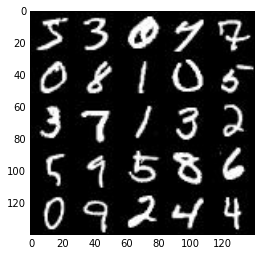

In [2]:
show_n_images = 25

%matplotlib inline

import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
O conjunto de dados [CelebA Attributes Dataset (CelebA)] (http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) contém mais de 200.000 imagens de celebridades com anotações. Como você vai gerar faces, não precisará das anotações. Você pode ver o primeiro número de exemplos mudando `show_n_images`.

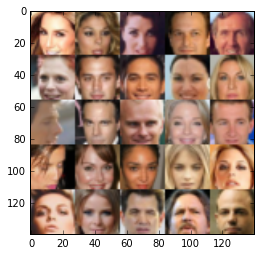

In [3]:
show_n_images = 25

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Pré-processar os dados
Como o foco principal do projeto é construir as GANs, nós pré-processaremos os dados para você. Os valores do conjunto de dados MNIST e CelebA estarão no intervalo de -0,5 a 0,5 de 28x28 imagens dimensionais. As imagens da CelebA serão cortadas para remover partes da imagem que não incluem um rosto e redimensionadas para 28x28.

As imagens MNIST são imagens em preto e branco com um único [canal de cor] (https://en.wikipedia.org/wiki/Channel_ (digital_image% 29), enquanto as imagens da CelebA têm [3 canais de cores (canal de cores RGB)] ( https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Construa a Rede Neural
Você construirá os componentes necessários para construir uma GAN implementando as seguintes funções abaixo:
- `model_inputs`
- `discriminador`
- `gerador`
- `model_loss`
- `model_opt`
- `train`

### Verifique a versão do TensorFlow e acesse o GPU
Isso irá verificar se você tem a versão correta do TensorFlow e acesso a uma GPU

In [4]:
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Verificar versão do Tensorflow
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Checar GPU
if not tf.test.gpu_device_name():
    warnings.warn('GPU Não encontrada. Por favor utilize uma GPU para treinar sua rede neural.')
else:
    print('GPU: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.8.0


C:\Users\jochagas\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:11: UserWarning: GPU Não encontrada. Por favor utilize uma GPU para treinar sua rede neural.


### Entrada
Implemente a função `model_inputs` para criar espaços reservados para TF para a rede neural. Deve criar os seguintes marcadores de posição:
- Espaçador de imagens de entrada real com classificação 4 usando `image_width`,` image_height` e `image_channels`.
- Espaço reservado de entrada Z com classificação 2 usando `z_dim`.
- Espaço reservado para a taxa de aprendizagem com classificação 0.

Retorna os marcadores de posição a seguir da tupla (tensor de imagens de entrada reais, tensor de dados z)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    input_feat = tf.placeholder(dtype=tf.float32, shape=(None, image_width, image_height, image_channels),
                              name='r_input')
    input_dim = tf.placeholder(dtype=tf.float32,shape=(None, z_dim), name='z_input')
    learning_rate = tf.placeholder(dtype=tf.float32, name='lr')

    return input_feat, input_dim, learning_rate

tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminador
Implemente `discriminator` para criar uma rede neural discriminadora que discrimine` images`. Esta função deve ser capaz de reutilizar as variáveis ​​na rede neural. Use [`tf.variable_scope`] (https://www.tensorflow.org/api_docs/python/tf/variable_scope) com um nome de escopo de" discriminador "para permitir que as variáveis ​​sejam reutilizadas. A função deve retornar uma tupla de (tensor output do discriminador, tensor logits do discriminador).

In [9]:
def discriminator(images, reuse=False):
    
    with tf.variable_scope('discriminator', reuse=reuse):
        
        alpha = 0.2
        dropout=0.9
        hl1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        hl1 = tf.maximum(alpha * hl1, hl1)
        
        hl2 = tf.layers.conv2d(hl1, 128, 5, strides=2, padding='same')
        hl2 = tf.layers.batch_normalization(hl2, training=True)
        hl2 = tf.maximum(alpha * hl2, hl2)
        
        hl3 = tf.layers.conv2d(hl2, 256, 5, strides=2, padding='same')
        hl3 = tf.layers.batch_normalization(hl3, training=True)
        hl3 = tf.maximum(alpha * hl3, hl3)

        inp_f = tf.reshape(hl3, (-1, 4*4*256))
        dl = tf.layers.dropout(inputs=inp_f, rate=dropout)
        logits = tf.layers.dense(dl, 1)
        output = tf.sigmoid(logits)
        
    return output, logits

tests.test_discriminator(discriminator, tf)

Tests Passed


### Gerador
Implemente `generator` para gerar uma imagem usando` z`. Esta função deve ser capaz de reutilizar as variáveis ​​na rede neural. Use [`tf.variable_scope`] (https://www.tensorflow.org/api_docs/python/tf/variable_scope) com um nome de escopo de" generator "para permitir que as variáveis ​​sejam reutilizadas. A função deve retornar as imagens 28 x 28 x `out_channel_dim` geradas.

In [12]:
def generator(z, out_channel_dim, is_train=True):
    with tf.variable_scope('generator', reuse= not is_train):
        
        alpha = 0.2
        dropout=0.9
        hl1 = tf.layers.dense(z, 3*3*512) # Dimensões
        hl1 = tf.reshape(hl1, (-1, 3, 3, 512)) # Novo shape
        hl1 = tf.layers.batch_normalization(hl1, training=is_train)
        hl1 = tf.maximum(alpha * hl1, hl1)
        
        hl2 = tf.layers.conv2d_transpose(hl1, 256, kernel_size=4, strides=2, padding='same')
        hl2 = tf.layers.batch_normalization(hl2, training=is_train)
        hl2 = tf.maximum(alpha * hl2, hl2)
        
        hl3 = tf.layers.conv2d_transpose(hl2, 128, kernel_size=4, strides=2, padding='valid')
        hl3 = tf.layers.batch_normalization(hl3, training=is_train)
        hl3 = tf.maximum(alpha * hl3, hl3)
        
        logits = tf.layers.conv2d_transpose(hl3, out_channel_dim, kernel_size=5,strides=2, padding='same')
        output = tf.tanh(logits)
        
        return output

tests.test_generator(generator, tf)

Tests Passed


### Perda
Implemente `model_loss` para construir as GANs para treinamento e calcular a perda. A função deve retornar uma tupla de (perda do discriminador, perda do gerador). Use as seguintes funções que você implementou:
- `discriminador (imagens, reutilização = Falso)`
- `gerador (z, out_channel_dim, is_train = True)`

In [33]:
def model_loss(input_real, input_z, out_channel_dim):

    smooth=0.1
    generatorr = generator(input_z, out_channel_dim, is_train=True)
    discriminatorr, r_logits = discriminator(input_real, reuse=False)
    f_model, f_logits = discriminator(generatorr, reuse=True)

    r_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=r_logits, 
                                                labels=tf.ones_like(discriminatorr)*(1 - smooth)))
    f_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=f_logits, labels=tf.zeros_like(f_model)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=f_logits, labels=tf.ones_like(f_model)))

    d_loss = r_loss + f_loss

    return d_loss, g_loss
    return None, None

tests.test_model_loss(model_loss)

Tests Passed


### Otimização
Implemente `model_opt` para criar as operações de otimização para as GANs. Use [`tf.trainable_variables`] (https://www.tensorflow.org/api_docs/python/tf/trainable_variables) para obter todas as variáveis ​​treináveis. Filtre as variáveis ​​com nomes que estão nos nomes do escopo do discriminador e do gerador. A função deve retornar uma tupla de (operação de treinamento do discriminador, operação de treinamento do gerador).

In [34]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    train_var = tf.trainable_variables()
    discriminator_var = [var for var in train_var if var.name.startswith('discriminator')]
    generator_var = [var for var in train_var if var.name.startswith('generator')]

    # Otimizzando...
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        dis_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=discriminator_var)
        gen_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=generator_var)

    return dis_train_opt, gen_train_opt

tests.test_model_opt(model_opt, tf)

Tests Passed


## Treinamento em Redes Neurais
### Show Output
Use esta função para mostrar a saída atual do gerador durante o treinamento. Isso ajudará você a determinar quão bem as GANs estão treinando.

In [35]:
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Treinar
Implementar o `train` para construir e treinar as GANs. Use as seguintes funções que você implementou:
- `model_inputs (image_width, image_height, image_channels, z_dim)`
- `model_loss (input_real, input_z, out_channel_dim)`
- `model_opt (d_loss, g_loss, learning_rate, beta1)`

Use o `show_generator_output` para mostrar a saída do` generator` enquanto você treina. Executar `show_generator_output` para cada lote aumentará drasticamente o tempo de treinamento e aumentará o tamanho do bloco de anotações. É recomendado imprimir a saída do `gerador` a cada 100 lotes.

In [36]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    
    print_step = 10
    show_step = 100
    leaky_alpha = 0.2
    dropout = 0.75
    images_to_show = 9
    losses =[]
    step = 0

    _, width, height, channels = data_shape
    
    r_input, z_input, lr = model_inputs(width, height, channels, z_dim)
    
    d_loss, g_loss = model_loss(r_input, z_input, channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    print("Starting trainning")
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                step += 1
                batch_images = 2*batch_images
                # Random Noise as input
                z_batch = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                _ = sess.run(d_opt, feed_dict={r_input: batch_images, z_input: z_batch, lr: learning_rate})
                # Let the generator run twice, so that the discriminator does not converge that fast.
                _ = sess.run(g_opt, feed_dict={z_input: z_batch, r_input: batch_images, lr: learning_rate})
                
                if step % print_step == 0:
                    train_loss_d = d_loss.eval({z_input: z_batch, r_input: batch_images})
                    train_loss_g = g_loss.eval({z_input: z_batch})
                    
                    print("Step: {}:".format(step),
                          "Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    losses.append((train_loss_d, train_loss_g))
                
                if step % show_step == 0:
                    show_generator_output(sess, images_to_show, z_input, channels, data_image_mode)
    print("Finished with trainning")

### MNIST
Teste sua arquitetura de GANs no MNIST. Depois de 2 épocas, as GANs devem poder gerar imagens que se pareçam com dígitos manuscritos. Certifique-se de que a perda do gerador seja menor que a perda do discriminador ou próxima de 0.

Starting trainning
Step: 10: Epoch 1/2... Discriminator Loss: 0.5417... Generator Loss: 2.4916
Step: 20: Epoch 1/2... Discriminator Loss: 1.6167... Generator Loss: 5.6153
Step: 30: Epoch 1/2... Discriminator Loss: 1.4107... Generator Loss: 2.8876
Step: 40: Epoch 1/2... Discriminator Loss: 1.5293... Generator Loss: 2.4970
Step: 50: Epoch 1/2... Discriminator Loss: 0.7148... Generator Loss: 1.4634
Step: 60: Epoch 1/2... Discriminator Loss: 0.7194... Generator Loss: 3.4664
Step: 70: Epoch 1/2... Discriminator Loss: 0.6228... Generator Loss: 1.5790
Step: 80: Epoch 1/2... Discriminator Loss: 0.5387... Generator Loss: 2.8097
Step: 90: Epoch 1/2... Discriminator Loss: 0.8067... Generator Loss: 1.2345
Step: 100: Epoch 1/2... Discriminator Loss: 1.4336... Generator Loss: 2.2086


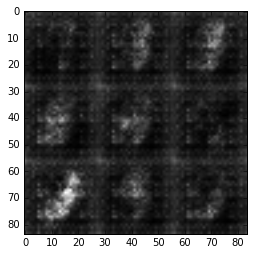

Step: 110: Epoch 1/2... Discriminator Loss: 0.9454... Generator Loss: 1.7892
Step: 120: Epoch 1/2... Discriminator Loss: 1.5801... Generator Loss: 0.4598
Step: 130: Epoch 1/2... Discriminator Loss: 0.8773... Generator Loss: 1.0724
Step: 140: Epoch 1/2... Discriminator Loss: 1.3383... Generator Loss: 0.6117
Step: 150: Epoch 1/2... Discriminator Loss: 0.9902... Generator Loss: 1.5759
Step: 160: Epoch 1/2... Discriminator Loss: 1.1933... Generator Loss: 0.6529
Step: 170: Epoch 1/2... Discriminator Loss: 1.4819... Generator Loss: 0.4938
Step: 180: Epoch 1/2... Discriminator Loss: 1.1067... Generator Loss: 0.7772
Step: 190: Epoch 1/2... Discriminator Loss: 1.0865... Generator Loss: 0.9823
Step: 200: Epoch 1/2... Discriminator Loss: 0.9710... Generator Loss: 1.4229


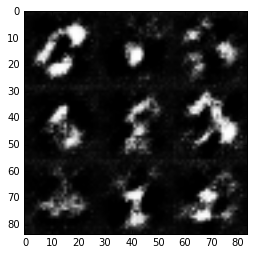

Step: 210: Epoch 1/2... Discriminator Loss: 1.2012... Generator Loss: 0.8067
Step: 220: Epoch 1/2... Discriminator Loss: 0.8082... Generator Loss: 1.7453
Step: 230: Epoch 1/2... Discriminator Loss: 0.8912... Generator Loss: 1.2661
Step: 240: Epoch 1/2... Discriminator Loss: 1.5141... Generator Loss: 0.4738
Step: 250: Epoch 1/2... Discriminator Loss: 1.1261... Generator Loss: 0.8687
Step: 260: Epoch 1/2... Discriminator Loss: 1.0756... Generator Loss: 2.1447
Step: 270: Epoch 1/2... Discriminator Loss: 1.2501... Generator Loss: 2.4894
Step: 280: Epoch 1/2... Discriminator Loss: 1.1310... Generator Loss: 2.0138
Step: 290: Epoch 1/2... Discriminator Loss: 1.1156... Generator Loss: 0.7869
Step: 300: Epoch 1/2... Discriminator Loss: 1.0679... Generator Loss: 0.9507


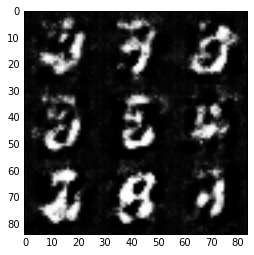

Step: 310: Epoch 1/2... Discriminator Loss: 0.8733... Generator Loss: 1.1755
Step: 320: Epoch 1/2... Discriminator Loss: 0.9944... Generator Loss: 1.0201
Step: 330: Epoch 1/2... Discriminator Loss: 1.3745... Generator Loss: 1.7766
Step: 340: Epoch 1/2... Discriminator Loss: 0.8637... Generator Loss: 1.3173
Step: 350: Epoch 1/2... Discriminator Loss: 0.7519... Generator Loss: 1.3319
Step: 360: Epoch 1/2... Discriminator Loss: 0.9042... Generator Loss: 1.2442
Step: 370: Epoch 1/2... Discriminator Loss: 1.4686... Generator Loss: 0.4377
Step: 380: Epoch 1/2... Discriminator Loss: 1.0739... Generator Loss: 0.7668
Step: 390: Epoch 1/2... Discriminator Loss: 0.8415... Generator Loss: 1.1770
Step: 400: Epoch 1/2... Discriminator Loss: 1.3570... Generator Loss: 0.5210


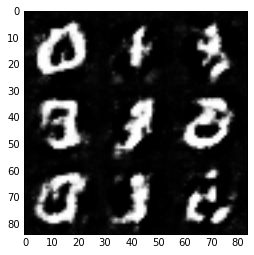

Step: 410: Epoch 1/2... Discriminator Loss: 0.9864... Generator Loss: 1.2612
Step: 420: Epoch 1/2... Discriminator Loss: 0.8935... Generator Loss: 1.1300
Step: 430: Epoch 1/2... Discriminator Loss: 0.7882... Generator Loss: 1.3958
Step: 440: Epoch 1/2... Discriminator Loss: 1.0563... Generator Loss: 0.8216
Step: 450: Epoch 1/2... Discriminator Loss: 0.9546... Generator Loss: 1.3663
Step: 460: Epoch 1/2... Discriminator Loss: 1.0998... Generator Loss: 0.8966
Step: 470: Epoch 1/2... Discriminator Loss: 0.7776... Generator Loss: 1.3851
Step: 480: Epoch 1/2... Discriminator Loss: 0.9636... Generator Loss: 1.7300
Step: 490: Epoch 1/2... Discriminator Loss: 1.2490... Generator Loss: 0.6865
Step: 500: Epoch 1/2... Discriminator Loss: 0.8482... Generator Loss: 1.1213


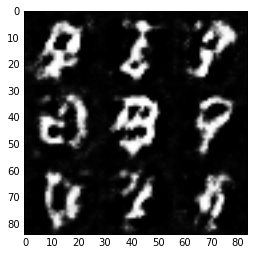

Step: 510: Epoch 1/2... Discriminator Loss: 1.2279... Generator Loss: 0.6093
Step: 520: Epoch 1/2... Discriminator Loss: 0.7058... Generator Loss: 1.3665
Step: 530: Epoch 1/2... Discriminator Loss: 1.0153... Generator Loss: 2.2366
Step: 540: Epoch 1/2... Discriminator Loss: 0.9519... Generator Loss: 0.9964
Step: 550: Epoch 1/2... Discriminator Loss: 1.1752... Generator Loss: 0.6920
Step: 560: Epoch 1/2... Discriminator Loss: 0.9129... Generator Loss: 1.4331
Step: 570: Epoch 1/2... Discriminator Loss: 1.0540... Generator Loss: 0.8595
Step: 580: Epoch 1/2... Discriminator Loss: 1.5009... Generator Loss: 2.8206
Step: 590: Epoch 1/2... Discriminator Loss: 0.8238... Generator Loss: 1.3446
Step: 600: Epoch 1/2... Discriminator Loss: 0.9814... Generator Loss: 0.9996


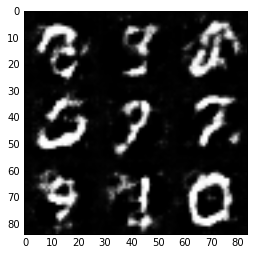

Step: 610: Epoch 1/2... Discriminator Loss: 1.0146... Generator Loss: 0.9173
Step: 620: Epoch 1/2... Discriminator Loss: 0.8083... Generator Loss: 1.3542
Step: 630: Epoch 1/2... Discriminator Loss: 1.0064... Generator Loss: 1.0236
Step: 640: Epoch 1/2... Discriminator Loss: 0.9757... Generator Loss: 0.9578
Step: 650: Epoch 1/2... Discriminator Loss: 1.5543... Generator Loss: 0.4308
Step: 660: Epoch 1/2... Discriminator Loss: 0.8992... Generator Loss: 1.0531
Step: 670: Epoch 1/2... Discriminator Loss: 1.4053... Generator Loss: 2.8719
Step: 680: Epoch 1/2... Discriminator Loss: 0.7857... Generator Loss: 1.2988
Step: 690: Epoch 1/2... Discriminator Loss: 1.6302... Generator Loss: 0.3629
Step: 700: Epoch 1/2... Discriminator Loss: 0.9061... Generator Loss: 1.1114


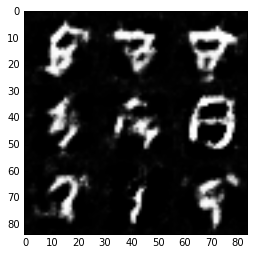

Step: 710: Epoch 1/2... Discriminator Loss: 1.5232... Generator Loss: 0.4019
Step: 720: Epoch 1/2... Discriminator Loss: 1.0179... Generator Loss: 1.0227
Step: 730: Epoch 1/2... Discriminator Loss: 0.9985... Generator Loss: 0.9426
Step: 740: Epoch 1/2... Discriminator Loss: 0.9312... Generator Loss: 1.0578
Step: 750: Epoch 1/2... Discriminator Loss: 1.3447... Generator Loss: 0.5553
Step: 760: Epoch 1/2... Discriminator Loss: 0.8042... Generator Loss: 2.4676
Step: 770: Epoch 1/2... Discriminator Loss: 1.0721... Generator Loss: 0.8523
Step: 780: Epoch 1/2... Discriminator Loss: 1.6785... Generator Loss: 0.3598
Step: 790: Epoch 1/2... Discriminator Loss: 1.2983... Generator Loss: 0.5950
Step: 800: Epoch 1/2... Discriminator Loss: 1.2129... Generator Loss: 0.6479


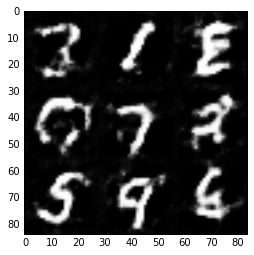

Step: 810: Epoch 1/2... Discriminator Loss: 0.7591... Generator Loss: 1.4692
Step: 820: Epoch 1/2... Discriminator Loss: 1.5800... Generator Loss: 0.4272
Step: 830: Epoch 1/2... Discriminator Loss: 1.1267... Generator Loss: 1.3729
Step: 840: Epoch 1/2... Discriminator Loss: 0.9410... Generator Loss: 1.6879
Step: 850: Epoch 1/2... Discriminator Loss: 1.0181... Generator Loss: 0.9512
Step: 860: Epoch 1/2... Discriminator Loss: 1.1406... Generator Loss: 0.6787
Step: 870: Epoch 1/2... Discriminator Loss: 1.0721... Generator Loss: 1.2574
Step: 880: Epoch 1/2... Discriminator Loss: 1.4425... Generator Loss: 0.4610
Step: 890: Epoch 1/2... Discriminator Loss: 1.0489... Generator Loss: 1.5519
Step: 900: Epoch 1/2... Discriminator Loss: 1.1617... Generator Loss: 0.7709


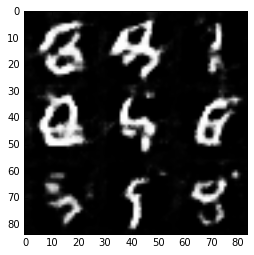

Step: 910: Epoch 1/2... Discriminator Loss: 1.1889... Generator Loss: 0.8452
Step: 920: Epoch 1/2... Discriminator Loss: 1.7275... Generator Loss: 0.3701
Step: 930: Epoch 1/2... Discriminator Loss: 1.0677... Generator Loss: 0.9350
Step: 940: Epoch 1/2... Discriminator Loss: 1.5939... Generator Loss: 0.4415
Step: 950: Epoch 1/2... Discriminator Loss: 0.8303... Generator Loss: 1.3347
Step: 960: Epoch 1/2... Discriminator Loss: 1.0805... Generator Loss: 1.9806
Step: 970: Epoch 1/2... Discriminator Loss: 1.0429... Generator Loss: 0.8506
Step: 980: Epoch 1/2... Discriminator Loss: 0.8211... Generator Loss: 1.6610
Step: 990: Epoch 1/2... Discriminator Loss: 1.0132... Generator Loss: 0.8554
Step: 1000: Epoch 1/2... Discriminator Loss: 1.5629... Generator Loss: 0.4302


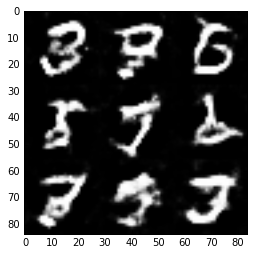

Step: 1010: Epoch 1/2... Discriminator Loss: 1.1322... Generator Loss: 1.6469
Step: 1020: Epoch 1/2... Discriminator Loss: 0.9670... Generator Loss: 1.7806
Step: 1030: Epoch 1/2... Discriminator Loss: 0.9105... Generator Loss: 1.1010
Step: 1040: Epoch 1/2... Discriminator Loss: 1.0084... Generator Loss: 1.2084
Step: 1050: Epoch 1/2... Discriminator Loss: 0.7547... Generator Loss: 1.6158
Step: 1060: Epoch 1/2... Discriminator Loss: 0.7861... Generator Loss: 1.3287
Step: 1070: Epoch 1/2... Discriminator Loss: 1.2052... Generator Loss: 0.6628
Step: 1080: Epoch 1/2... Discriminator Loss: 0.8520... Generator Loss: 1.2108
Step: 1090: Epoch 1/2... Discriminator Loss: 0.8103... Generator Loss: 1.2269
Step: 1100: Epoch 1/2... Discriminator Loss: 1.0008... Generator Loss: 0.8223


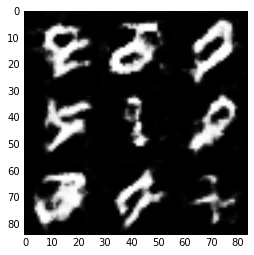

Step: 1110: Epoch 1/2... Discriminator Loss: 0.9086... Generator Loss: 1.2192
Step: 1120: Epoch 1/2... Discriminator Loss: 1.0156... Generator Loss: 1.8968
Step: 1130: Epoch 1/2... Discriminator Loss: 0.8842... Generator Loss: 1.0321
Step: 1140: Epoch 1/2... Discriminator Loss: 1.2405... Generator Loss: 0.6333
Step: 1150: Epoch 1/2... Discriminator Loss: 0.9593... Generator Loss: 1.1784
Step: 1160: Epoch 1/2... Discriminator Loss: 0.9629... Generator Loss: 1.1954
Step: 1170: Epoch 1/2... Discriminator Loss: 0.9318... Generator Loss: 1.1821
Step: 1180: Epoch 1/2... Discriminator Loss: 1.4391... Generator Loss: 0.4619
Step: 1190: Epoch 1/2... Discriminator Loss: 1.1564... Generator Loss: 0.7435
Step: 1200: Epoch 1/2... Discriminator Loss: 0.7320... Generator Loss: 1.9066


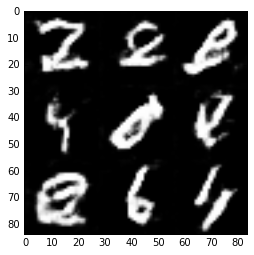

Step: 1210: Epoch 1/2... Discriminator Loss: 0.7814... Generator Loss: 1.3241
Step: 1220: Epoch 1/2... Discriminator Loss: 0.8158... Generator Loss: 1.4079
Step: 1230: Epoch 1/2... Discriminator Loss: 1.0139... Generator Loss: 0.8689
Step: 1240: Epoch 1/2... Discriminator Loss: 1.4493... Generator Loss: 0.5041
Step: 1250: Epoch 1/2... Discriminator Loss: 3.1336... Generator Loss: 0.1181
Step: 1260: Epoch 1/2... Discriminator Loss: 0.9594... Generator Loss: 0.9700
Step: 1270: Epoch 1/2... Discriminator Loss: 1.1049... Generator Loss: 0.8105
Step: 1280: Epoch 1/2... Discriminator Loss: 0.8094... Generator Loss: 1.0899
Step: 1290: Epoch 1/2... Discriminator Loss: 0.9887... Generator Loss: 0.8193
Step: 1300: Epoch 1/2... Discriminator Loss: 1.1498... Generator Loss: 0.7060


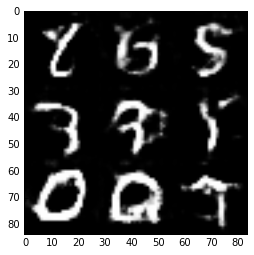

Step: 1310: Epoch 1/2... Discriminator Loss: 1.7219... Generator Loss: 0.4753
Step: 1320: Epoch 1/2... Discriminator Loss: 1.0745... Generator Loss: 0.8008
Step: 1330: Epoch 1/2... Discriminator Loss: 1.3611... Generator Loss: 0.4903
Step: 1340: Epoch 1/2... Discriminator Loss: 0.9130... Generator Loss: 0.9376
Step: 1350: Epoch 1/2... Discriminator Loss: 1.3723... Generator Loss: 0.5403
Step: 1360: Epoch 1/2... Discriminator Loss: 1.1973... Generator Loss: 0.7883
Step: 1370: Epoch 1/2... Discriminator Loss: 0.9062... Generator Loss: 0.9737
Step: 1380: Epoch 1/2... Discriminator Loss: 0.7201... Generator Loss: 1.3162
Step: 1390: Epoch 1/2... Discriminator Loss: 0.9080... Generator Loss: 1.0323
Step: 1400: Epoch 1/2... Discriminator Loss: 0.9837... Generator Loss: 0.8792


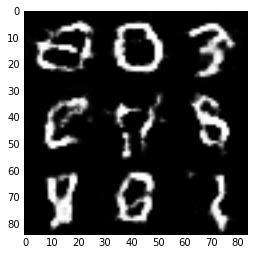

Step: 1410: Epoch 1/2... Discriminator Loss: 0.8459... Generator Loss: 1.1179
Step: 1420: Epoch 1/2... Discriminator Loss: 1.2260... Generator Loss: 0.7409
Step: 1430: Epoch 1/2... Discriminator Loss: 0.9048... Generator Loss: 2.2032
Step: 1440: Epoch 1/2... Discriminator Loss: 1.1091... Generator Loss: 0.9639
Step: 1450: Epoch 1/2... Discriminator Loss: 1.0040... Generator Loss: 0.8978
Step: 1460: Epoch 1/2... Discriminator Loss: 0.9678... Generator Loss: 0.9892
Step: 1470: Epoch 1/2... Discriminator Loss: 0.9579... Generator Loss: 0.8861
Step: 1480: Epoch 1/2... Discriminator Loss: 0.7011... Generator Loss: 1.3137
Step: 1490: Epoch 1/2... Discriminator Loss: 0.8467... Generator Loss: 1.2091
Step: 1500: Epoch 1/2... Discriminator Loss: 0.8072... Generator Loss: 1.1128


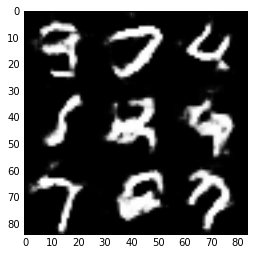

Step: 1510: Epoch 1/2... Discriminator Loss: 1.4836... Generator Loss: 0.4316
Step: 1520: Epoch 1/2... Discriminator Loss: 3.0656... Generator Loss: 0.1122
Step: 1530: Epoch 1/2... Discriminator Loss: 0.9151... Generator Loss: 0.9387
Step: 1540: Epoch 1/2... Discriminator Loss: 0.8924... Generator Loss: 1.0594
Step: 1550: Epoch 1/2... Discriminator Loss: 1.0685... Generator Loss: 0.9060
Step: 1560: Epoch 1/2... Discriminator Loss: 0.8957... Generator Loss: 1.0094
Step: 1570: Epoch 1/2... Discriminator Loss: 0.7684... Generator Loss: 1.2245
Step: 1580: Epoch 1/2... Discriminator Loss: 1.0388... Generator Loss: 0.8701
Step: 1590: Epoch 1/2... Discriminator Loss: 0.7970... Generator Loss: 1.1330
Step: 1600: Epoch 1/2... Discriminator Loss: 1.0520... Generator Loss: 0.7988


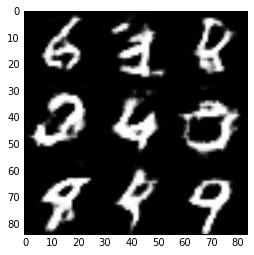

Step: 1610: Epoch 1/2... Discriminator Loss: 0.9100... Generator Loss: 1.0195
Step: 1620: Epoch 1/2... Discriminator Loss: 0.9912... Generator Loss: 0.8692
Step: 1630: Epoch 1/2... Discriminator Loss: 1.9771... Generator Loss: 3.8714
Step: 1640: Epoch 1/2... Discriminator Loss: 0.7713... Generator Loss: 1.1872
Step: 1650: Epoch 1/2... Discriminator Loss: 0.7731... Generator Loss: 1.3110
Step: 1660: Epoch 1/2... Discriminator Loss: 0.7722... Generator Loss: 1.3396
Step: 1670: Epoch 1/2... Discriminator Loss: 1.1634... Generator Loss: 0.6912
Step: 1680: Epoch 1/2... Discriminator Loss: 0.6707... Generator Loss: 1.6312
Step: 1690: Epoch 1/2... Discriminator Loss: 0.9243... Generator Loss: 1.1807
Step: 1700: Epoch 1/2... Discriminator Loss: 0.7710... Generator Loss: 1.1773


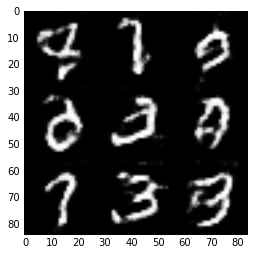

Step: 1710: Epoch 1/2... Discriminator Loss: 0.7804... Generator Loss: 1.1352
Step: 1720: Epoch 1/2... Discriminator Loss: 0.5761... Generator Loss: 2.0120
Step: 1730: Epoch 1/2... Discriminator Loss: 1.6313... Generator Loss: 0.6722
Step: 1740: Epoch 1/2... Discriminator Loss: 1.7724... Generator Loss: 3.5482
Step: 1750: Epoch 1/2... Discriminator Loss: 0.9355... Generator Loss: 1.7336
Step: 1760: Epoch 1/2... Discriminator Loss: 1.3657... Generator Loss: 0.5728
Step: 1770: Epoch 1/2... Discriminator Loss: 0.8739... Generator Loss: 1.1953
Step: 1780: Epoch 1/2... Discriminator Loss: 0.7879... Generator Loss: 1.2381
Step: 1790: Epoch 1/2... Discriminator Loss: 0.6648... Generator Loss: 1.7527
Step: 1800: Epoch 1/2... Discriminator Loss: 0.6515... Generator Loss: 1.5669


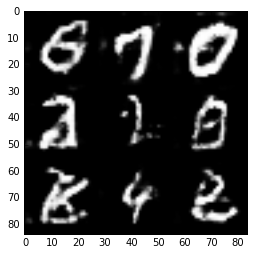

Step: 1810: Epoch 1/2... Discriminator Loss: 0.9858... Generator Loss: 1.1950
Step: 1820: Epoch 1/2... Discriminator Loss: 0.9523... Generator Loss: 0.9320
Step: 1830: Epoch 1/2... Discriminator Loss: 0.9389... Generator Loss: 1.5637
Step: 1840: Epoch 1/2... Discriminator Loss: 0.7978... Generator Loss: 1.1466
Step: 1850: Epoch 1/2... Discriminator Loss: 1.5171... Generator Loss: 0.4461
Step: 1860: Epoch 1/2... Discriminator Loss: 1.0955... Generator Loss: 0.7245
Step: 1870: Epoch 1/2... Discriminator Loss: 0.5923... Generator Loss: 1.6884
Step: 1880: Epoch 2/2... Discriminator Loss: 0.6977... Generator Loss: 1.4116
Step: 1890: Epoch 2/2... Discriminator Loss: 0.8421... Generator Loss: 1.2730
Step: 1900: Epoch 2/2... Discriminator Loss: 0.6682... Generator Loss: 1.6419


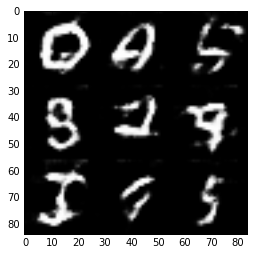

Step: 1910: Epoch 2/2... Discriminator Loss: 0.9742... Generator Loss: 1.0126
Step: 1920: Epoch 2/2... Discriminator Loss: 0.8884... Generator Loss: 1.0424
Step: 1930: Epoch 2/2... Discriminator Loss: 0.8815... Generator Loss: 1.0625
Step: 1940: Epoch 2/2... Discriminator Loss: 0.9941... Generator Loss: 0.8242
Step: 1950: Epoch 2/2... Discriminator Loss: 1.9870... Generator Loss: 0.3433
Step: 1960: Epoch 2/2... Discriminator Loss: 0.7033... Generator Loss: 1.4978
Step: 1970: Epoch 2/2... Discriminator Loss: 0.9821... Generator Loss: 0.8899
Step: 1980: Epoch 2/2... Discriminator Loss: 0.7876... Generator Loss: 1.5880
Step: 1990: Epoch 2/2... Discriminator Loss: 0.8623... Generator Loss: 1.0226
Step: 2000: Epoch 2/2... Discriminator Loss: 0.8250... Generator Loss: 2.4828


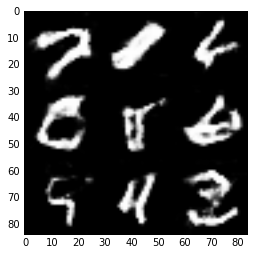

Step: 2010: Epoch 2/2... Discriminator Loss: 1.0526... Generator Loss: 0.8298
Step: 2020: Epoch 2/2... Discriminator Loss: 0.6249... Generator Loss: 1.5857
Step: 2030: Epoch 2/2... Discriminator Loss: 1.2306... Generator Loss: 0.6740
Step: 2040: Epoch 2/2... Discriminator Loss: 0.6336... Generator Loss: 1.7153
Step: 2050: Epoch 2/2... Discriminator Loss: 1.5153... Generator Loss: 0.4495
Step: 2060: Epoch 2/2... Discriminator Loss: 0.9417... Generator Loss: 1.0505
Step: 2070: Epoch 2/2... Discriminator Loss: 0.7348... Generator Loss: 1.3130
Step: 2080: Epoch 2/2... Discriminator Loss: 1.0616... Generator Loss: 0.7919
Step: 2090: Epoch 2/2... Discriminator Loss: 1.0706... Generator Loss: 0.7999
Step: 2100: Epoch 2/2... Discriminator Loss: 0.8649... Generator Loss: 1.1024


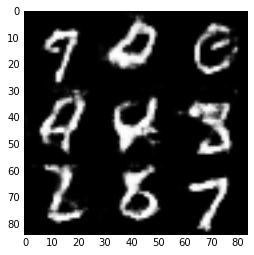

Step: 2110: Epoch 2/2... Discriminator Loss: 0.7991... Generator Loss: 1.6725
Step: 2120: Epoch 2/2... Discriminator Loss: 0.7101... Generator Loss: 1.7547
Step: 2130: Epoch 2/2... Discriminator Loss: 0.7843... Generator Loss: 1.1961
Step: 2140: Epoch 2/2... Discriminator Loss: 0.7365... Generator Loss: 1.2556
Step: 2150: Epoch 2/2... Discriminator Loss: 0.8633... Generator Loss: 1.0172
Step: 2160: Epoch 2/2... Discriminator Loss: 1.1466... Generator Loss: 0.7318
Step: 2170: Epoch 2/2... Discriminator Loss: 1.4267... Generator Loss: 0.4873
Step: 2180: Epoch 2/2... Discriminator Loss: 0.7873... Generator Loss: 1.1656
Step: 2190: Epoch 2/2... Discriminator Loss: 0.5942... Generator Loss: 1.8335
Step: 2200: Epoch 2/2... Discriminator Loss: 1.2713... Generator Loss: 0.6152


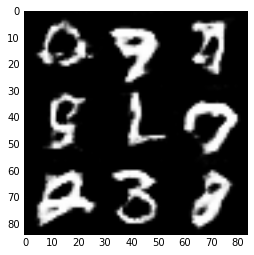

Step: 2210: Epoch 2/2... Discriminator Loss: 0.9392... Generator Loss: 0.9069
Step: 2220: Epoch 2/2... Discriminator Loss: 0.7143... Generator Loss: 1.3270
Step: 2230: Epoch 2/2... Discriminator Loss: 0.8196... Generator Loss: 1.1634
Step: 2240: Epoch 2/2... Discriminator Loss: 0.6540... Generator Loss: 1.4051
Step: 2250: Epoch 2/2... Discriminator Loss: 0.8860... Generator Loss: 0.9976
Step: 2260: Epoch 2/2... Discriminator Loss: 0.8349... Generator Loss: 1.1686
Step: 2270: Epoch 2/2... Discriminator Loss: 0.8771... Generator Loss: 1.1625
Step: 2280: Epoch 2/2... Discriminator Loss: 0.9618... Generator Loss: 0.9463
Step: 2290: Epoch 2/2... Discriminator Loss: 1.2572... Generator Loss: 0.6478
Step: 2300: Epoch 2/2... Discriminator Loss: 0.7442... Generator Loss: 2.1766


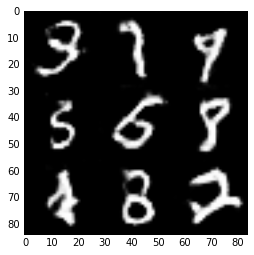

Step: 2310: Epoch 2/2... Discriminator Loss: 0.8256... Generator Loss: 2.1267
Step: 2320: Epoch 2/2... Discriminator Loss: 0.8883... Generator Loss: 0.9583
Step: 2330: Epoch 2/2... Discriminator Loss: 1.9324... Generator Loss: 0.3404
Step: 2340: Epoch 2/2... Discriminator Loss: 0.7812... Generator Loss: 1.5055
Step: 2350: Epoch 2/2... Discriminator Loss: 0.6596... Generator Loss: 1.4701
Step: 2360: Epoch 2/2... Discriminator Loss: 0.7476... Generator Loss: 1.2392
Step: 2370: Epoch 2/2... Discriminator Loss: 0.6679... Generator Loss: 1.4173
Step: 2380: Epoch 2/2... Discriminator Loss: 0.9816... Generator Loss: 0.8901
Step: 2390: Epoch 2/2... Discriminator Loss: 0.8357... Generator Loss: 1.1789
Step: 2400: Epoch 2/2... Discriminator Loss: 0.9132... Generator Loss: 0.9956


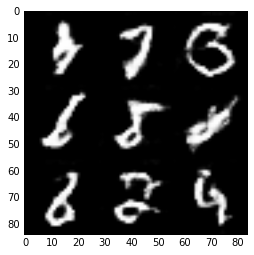

Step: 2410: Epoch 2/2... Discriminator Loss: 0.8468... Generator Loss: 1.0616
Step: 2420: Epoch 2/2... Discriminator Loss: 0.7712... Generator Loss: 1.2335
Step: 2430: Epoch 2/2... Discriminator Loss: 0.7585... Generator Loss: 1.1779
Step: 2440: Epoch 2/2... Discriminator Loss: 1.2228... Generator Loss: 0.6859
Step: 2450: Epoch 2/2... Discriminator Loss: 1.3827... Generator Loss: 0.5928
Step: 2460: Epoch 2/2... Discriminator Loss: 0.7680... Generator Loss: 1.4184
Step: 2470: Epoch 2/2... Discriminator Loss: 0.8122... Generator Loss: 1.3002
Step: 2480: Epoch 2/2... Discriminator Loss: 1.0755... Generator Loss: 0.7630
Step: 2490: Epoch 2/2... Discriminator Loss: 1.0293... Generator Loss: 0.8237
Step: 2500: Epoch 2/2... Discriminator Loss: 1.0333... Generator Loss: 0.7637


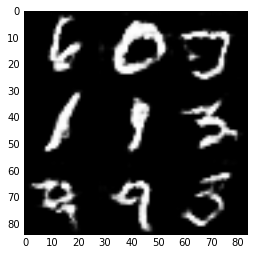

Step: 2510: Epoch 2/2... Discriminator Loss: 0.9683... Generator Loss: 0.9035
Step: 2520: Epoch 2/2... Discriminator Loss: 0.6092... Generator Loss: 2.2040
Step: 2530: Epoch 2/2... Discriminator Loss: 1.0452... Generator Loss: 0.8532
Step: 2540: Epoch 2/2... Discriminator Loss: 0.7102... Generator Loss: 1.7198
Step: 2550: Epoch 2/2... Discriminator Loss: 1.6902... Generator Loss: 0.4042
Step: 2560: Epoch 2/2... Discriminator Loss: 1.5698... Generator Loss: 0.4582
Step: 2570: Epoch 2/2... Discriminator Loss: 0.7818... Generator Loss: 1.2967
Step: 2580: Epoch 2/2... Discriminator Loss: 0.7441... Generator Loss: 1.2552
Step: 2590: Epoch 2/2... Discriminator Loss: 0.9330... Generator Loss: 0.9595
Step: 2600: Epoch 2/2... Discriminator Loss: 0.7789... Generator Loss: 1.3644


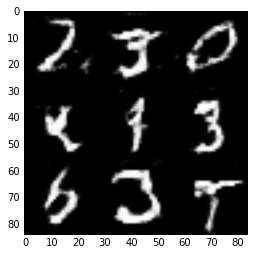

Step: 2610: Epoch 2/2... Discriminator Loss: 0.9923... Generator Loss: 0.8104
Step: 2620: Epoch 2/2... Discriminator Loss: 0.7270... Generator Loss: 1.3728
Step: 2630: Epoch 2/2... Discriminator Loss: 0.8120... Generator Loss: 1.1964
Step: 2640: Epoch 2/2... Discriminator Loss: 1.5425... Generator Loss: 0.4997
Step: 2650: Epoch 2/2... Discriminator Loss: 1.1540... Generator Loss: 0.7489
Step: 2660: Epoch 2/2... Discriminator Loss: 1.7179... Generator Loss: 0.4236
Step: 2670: Epoch 2/2... Discriminator Loss: 0.8236... Generator Loss: 1.1688
Step: 2680: Epoch 2/2... Discriminator Loss: 0.6286... Generator Loss: 1.7064
Step: 2690: Epoch 2/2... Discriminator Loss: 0.6633... Generator Loss: 1.4595
Step: 2700: Epoch 2/2... Discriminator Loss: 1.4637... Generator Loss: 0.5418


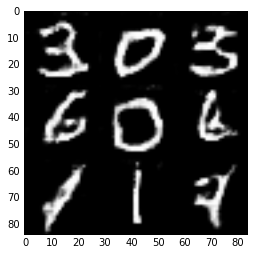

Step: 2710: Epoch 2/2... Discriminator Loss: 0.5311... Generator Loss: 1.9879
Step: 2720: Epoch 2/2... Discriminator Loss: 0.7110... Generator Loss: 1.5866
Step: 2730: Epoch 2/2... Discriminator Loss: 1.4599... Generator Loss: 0.5809
Step: 2740: Epoch 2/2... Discriminator Loss: 0.7493... Generator Loss: 1.6446
Step: 2750: Epoch 2/2... Discriminator Loss: 1.3475... Generator Loss: 0.7163
Step: 2760: Epoch 2/2... Discriminator Loss: 1.1724... Generator Loss: 0.7741
Step: 2770: Epoch 2/2... Discriminator Loss: 1.0170... Generator Loss: 0.9907
Step: 2780: Epoch 2/2... Discriminator Loss: 0.6715... Generator Loss: 1.5008
Step: 2790: Epoch 2/2... Discriminator Loss: 1.0185... Generator Loss: 0.8199
Step: 2800: Epoch 2/2... Discriminator Loss: 0.6976... Generator Loss: 1.3476


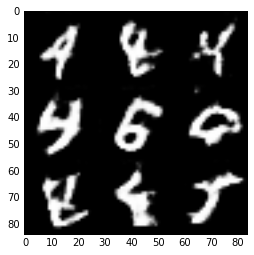

Step: 2810: Epoch 2/2... Discriminator Loss: 0.8100... Generator Loss: 2.9095
Step: 2820: Epoch 2/2... Discriminator Loss: 0.8389... Generator Loss: 1.0904
Step: 2830: Epoch 2/2... Discriminator Loss: 0.6206... Generator Loss: 1.8354
Step: 2840: Epoch 2/2... Discriminator Loss: 0.6531... Generator Loss: 1.5561
Step: 2850: Epoch 2/2... Discriminator Loss: 0.6781... Generator Loss: 1.4181
Step: 2860: Epoch 2/2... Discriminator Loss: 0.6862... Generator Loss: 1.7620
Step: 2870: Epoch 2/2... Discriminator Loss: 0.7458... Generator Loss: 1.3166
Step: 2880: Epoch 2/2... Discriminator Loss: 1.0818... Generator Loss: 0.8097
Step: 2890: Epoch 2/2... Discriminator Loss: 0.9486... Generator Loss: 0.9519
Step: 2900: Epoch 2/2... Discriminator Loss: 0.8671... Generator Loss: 1.0310


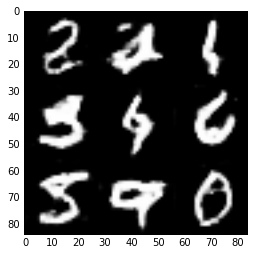

Step: 2910: Epoch 2/2... Discriminator Loss: 0.5918... Generator Loss: 1.9896
Step: 2920: Epoch 2/2... Discriminator Loss: 0.9754... Generator Loss: 0.8845
Step: 2930: Epoch 2/2... Discriminator Loss: 0.5408... Generator Loss: 2.1370
Step: 2940: Epoch 2/2... Discriminator Loss: 1.1158... Generator Loss: 0.7079
Step: 2950: Epoch 2/2... Discriminator Loss: 0.6332... Generator Loss: 1.5778
Step: 2960: Epoch 2/2... Discriminator Loss: 0.6587... Generator Loss: 1.4455
Step: 2970: Epoch 2/2... Discriminator Loss: 0.7776... Generator Loss: 1.7065
Step: 2980: Epoch 2/2... Discriminator Loss: 1.2684... Generator Loss: 0.5422
Step: 2990: Epoch 2/2... Discriminator Loss: 0.7622... Generator Loss: 1.5289
Step: 3000: Epoch 2/2... Discriminator Loss: 0.5940... Generator Loss: 1.9349


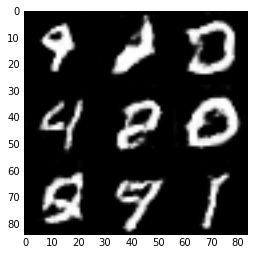

Step: 3010: Epoch 2/2... Discriminator Loss: 0.9119... Generator Loss: 0.9924
Step: 3020: Epoch 2/2... Discriminator Loss: 0.9088... Generator Loss: 2.1806
Step: 3030: Epoch 2/2... Discriminator Loss: 1.0063... Generator Loss: 0.8688
Step: 3040: Epoch 2/2... Discriminator Loss: 1.2212... Generator Loss: 0.7583
Step: 3050: Epoch 2/2... Discriminator Loss: 1.0744... Generator Loss: 0.8030
Step: 3060: Epoch 2/2... Discriminator Loss: 0.5063... Generator Loss: 2.1013
Step: 3070: Epoch 2/2... Discriminator Loss: 0.7637... Generator Loss: 1.3497
Step: 3080: Epoch 2/2... Discriminator Loss: 0.6889... Generator Loss: 1.3757
Step: 3090: Epoch 2/2... Discriminator Loss: 1.7540... Generator Loss: 0.3894
Step: 3100: Epoch 2/2... Discriminator Loss: 0.7673... Generator Loss: 1.3581


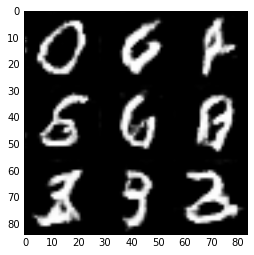

Step: 3110: Epoch 2/2... Discriminator Loss: 0.6987... Generator Loss: 2.7413
Step: 3120: Epoch 2/2... Discriminator Loss: 0.8009... Generator Loss: 1.2350
Step: 3130: Epoch 2/2... Discriminator Loss: 0.7071... Generator Loss: 1.8044
Step: 3140: Epoch 2/2... Discriminator Loss: 1.3072... Generator Loss: 0.5511
Step: 3150: Epoch 2/2... Discriminator Loss: 0.7022... Generator Loss: 1.3512
Step: 3160: Epoch 2/2... Discriminator Loss: 0.6960... Generator Loss: 1.3847
Step: 3170: Epoch 2/2... Discriminator Loss: 0.7433... Generator Loss: 2.3217
Step: 3180: Epoch 2/2... Discriminator Loss: 1.0698... Generator Loss: 0.8159
Step: 3190: Epoch 2/2... Discriminator Loss: 0.6405... Generator Loss: 1.5242
Step: 3200: Epoch 2/2... Discriminator Loss: 2.7249... Generator Loss: 0.2229


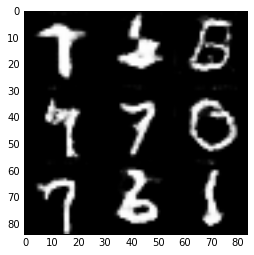

Step: 3210: Epoch 2/2... Discriminator Loss: 0.7160... Generator Loss: 2.1330
Step: 3220: Epoch 2/2... Discriminator Loss: 1.3627... Generator Loss: 0.5207
Step: 3230: Epoch 2/2... Discriminator Loss: 0.8412... Generator Loss: 1.2407
Step: 3240: Epoch 2/2... Discriminator Loss: 0.8047... Generator Loss: 2.3992
Step: 3250: Epoch 2/2... Discriminator Loss: 0.7371... Generator Loss: 1.3979
Step: 3260: Epoch 2/2... Discriminator Loss: 0.8274... Generator Loss: 1.1188
Step: 3270: Epoch 2/2... Discriminator Loss: 0.6052... Generator Loss: 1.6680
Step: 3280: Epoch 2/2... Discriminator Loss: 1.1694... Generator Loss: 1.7979
Step: 3290: Epoch 2/2... Discriminator Loss: 0.9384... Generator Loss: 0.9404
Step: 3300: Epoch 2/2... Discriminator Loss: 0.7319... Generator Loss: 1.2751


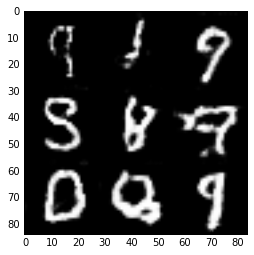

Step: 3310: Epoch 2/2... Discriminator Loss: 0.6982... Generator Loss: 1.5276
Step: 3320: Epoch 2/2... Discriminator Loss: 0.6230... Generator Loss: 1.6288
Step: 3330: Epoch 2/2... Discriminator Loss: 0.7658... Generator Loss: 1.2988
Step: 3340: Epoch 2/2... Discriminator Loss: 0.6075... Generator Loss: 2.7405
Step: 3350: Epoch 2/2... Discriminator Loss: 0.9946... Generator Loss: 2.5528
Step: 3360: Epoch 2/2... Discriminator Loss: 0.5562... Generator Loss: 1.7505
Step: 3370: Epoch 2/2... Discriminator Loss: 0.7894... Generator Loss: 1.5826
Step: 3380: Epoch 2/2... Discriminator Loss: 0.7874... Generator Loss: 1.2074
Step: 3390: Epoch 2/2... Discriminator Loss: 0.6685... Generator Loss: 1.4818
Step: 3400: Epoch 2/2... Discriminator Loss: 1.1075... Generator Loss: 0.7179


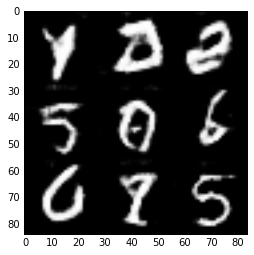

Step: 3410: Epoch 2/2... Discriminator Loss: 1.0914... Generator Loss: 0.7781
Step: 3420: Epoch 2/2... Discriminator Loss: 1.3078... Generator Loss: 3.0760
Step: 3430: Epoch 2/2... Discriminator Loss: 1.1128... Generator Loss: 0.7349
Step: 3440: Epoch 2/2... Discriminator Loss: 0.6891... Generator Loss: 1.6901
Step: 3450: Epoch 2/2... Discriminator Loss: 0.8199... Generator Loss: 1.0600
Step: 3460: Epoch 2/2... Discriminator Loss: 0.8160... Generator Loss: 1.0896
Step: 3470: Epoch 2/2... Discriminator Loss: 0.5405... Generator Loss: 1.8917
Step: 3480: Epoch 2/2... Discriminator Loss: 0.6105... Generator Loss: 1.5957
Step: 3490: Epoch 2/2... Discriminator Loss: 1.3400... Generator Loss: 3.9556
Step: 3500: Epoch 2/2... Discriminator Loss: 0.8103... Generator Loss: 1.2754


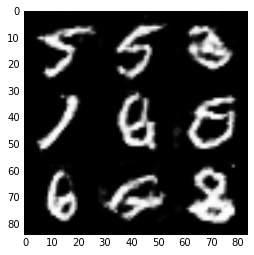

Step: 3510: Epoch 2/2... Discriminator Loss: 0.8938... Generator Loss: 1.1199
Step: 3520: Epoch 2/2... Discriminator Loss: 1.1244... Generator Loss: 0.7680
Step: 3530: Epoch 2/2... Discriminator Loss: 0.8385... Generator Loss: 1.0948
Step: 3540: Epoch 2/2... Discriminator Loss: 0.5563... Generator Loss: 1.8383
Step: 3550: Epoch 2/2... Discriminator Loss: 0.6920... Generator Loss: 1.2873
Step: 3560: Epoch 2/2... Discriminator Loss: 0.6344... Generator Loss: 1.4567
Step: 3570: Epoch 2/2... Discriminator Loss: 1.6690... Generator Loss: 0.4664
Step: 3580: Epoch 2/2... Discriminator Loss: 0.8394... Generator Loss: 1.1240
Step: 3590: Epoch 2/2... Discriminator Loss: 0.8482... Generator Loss: 1.3366
Step: 3600: Epoch 2/2... Discriminator Loss: 0.6821... Generator Loss: 2.1073


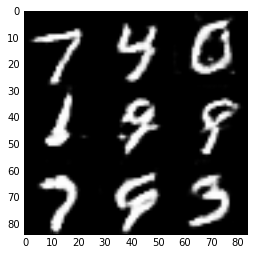

Step: 3610: Epoch 2/2... Discriminator Loss: 0.4884... Generator Loss: 2.4252
Step: 3620: Epoch 2/2... Discriminator Loss: 1.1407... Generator Loss: 2.6305
Step: 3630: Epoch 2/2... Discriminator Loss: 0.7027... Generator Loss: 1.4497
Step: 3640: Epoch 2/2... Discriminator Loss: 1.1438... Generator Loss: 0.7164
Step: 3650: Epoch 2/2... Discriminator Loss: 0.6478... Generator Loss: 1.4850
Step: 3660: Epoch 2/2... Discriminator Loss: 0.7925... Generator Loss: 1.2522
Step: 3670: Epoch 2/2... Discriminator Loss: 0.7883... Generator Loss: 1.1500
Step: 3680: Epoch 2/2... Discriminator Loss: 0.8485... Generator Loss: 1.0188
Step: 3690: Epoch 2/2... Discriminator Loss: 1.2761... Generator Loss: 0.7204
Step: 3700: Epoch 2/2... Discriminator Loss: 1.4804... Generator Loss: 3.5478


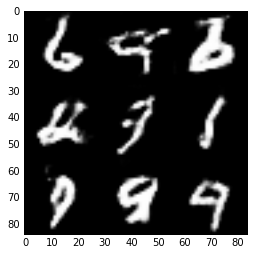

Step: 3710: Epoch 2/2... Discriminator Loss: 0.8706... Generator Loss: 3.4775
Step: 3720: Epoch 2/2... Discriminator Loss: 0.7628... Generator Loss: 2.4696
Step: 3730: Epoch 2/2... Discriminator Loss: 0.9410... Generator Loss: 1.0272
Step: 3740: Epoch 2/2... Discriminator Loss: 0.7102... Generator Loss: 1.5433
Step: 3750: Epoch 2/2... Discriminator Loss: 0.9630... Generator Loss: 0.9503
Finished with trainning


In [37]:
batch_size = 32
z_dim = 200
learning_rate = 0.0002
beta1 = 0.3

epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Execute suas GANs na CelebA. Demora cerca de 20 minutos na GPU média para executar uma época. Você pode executar toda a época ou parar quando começar a gerar faces realistas.

Starting trainning
Step: 10: Epoch 1/1... Discriminator Loss: 0.7890... Generator Loss: 1.4086
Step: 20: Epoch 1/1... Discriminator Loss: 0.7553... Generator Loss: 1.4292
Step: 30: Epoch 1/1... Discriminator Loss: 0.9551... Generator Loss: 1.0209
Step: 40: Epoch 1/1... Discriminator Loss: 1.7738... Generator Loss: 9.7082
Step: 50: Epoch 1/1... Discriminator Loss: 0.4880... Generator Loss: 3.9898
Step: 60: Epoch 1/1... Discriminator Loss: 1.4937... Generator Loss: 0.4821
Step: 70: Epoch 1/1... Discriminator Loss: 1.6775... Generator Loss: 0.4149
Step: 80: Epoch 1/1... Discriminator Loss: 1.3091... Generator Loss: 0.6003
Step: 90: Epoch 1/1... Discriminator Loss: 0.7648... Generator Loss: 2.3153
Step: 100: Epoch 1/1... Discriminator Loss: 1.1372... Generator Loss: 2.1389


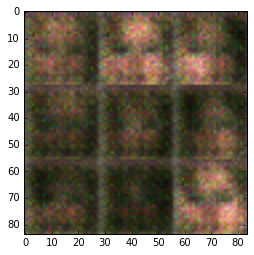

Step: 110: Epoch 1/1... Discriminator Loss: 0.9242... Generator Loss: 1.1979
Step: 120: Epoch 1/1... Discriminator Loss: 1.1359... Generator Loss: 0.7190
Step: 130: Epoch 1/1... Discriminator Loss: 1.2659... Generator Loss: 0.6100
Step: 140: Epoch 1/1... Discriminator Loss: 2.3381... Generator Loss: 5.5036
Step: 150: Epoch 1/1... Discriminator Loss: 0.8452... Generator Loss: 2.8298
Step: 160: Epoch 1/1... Discriminator Loss: 1.4829... Generator Loss: 0.5418
Step: 170: Epoch 1/1... Discriminator Loss: 1.9116... Generator Loss: 0.3221
Step: 180: Epoch 1/1... Discriminator Loss: 1.0275... Generator Loss: 0.8842
Step: 190: Epoch 1/1... Discriminator Loss: 0.8022... Generator Loss: 2.1722
Step: 200: Epoch 1/1... Discriminator Loss: 1.0640... Generator Loss: 0.9514


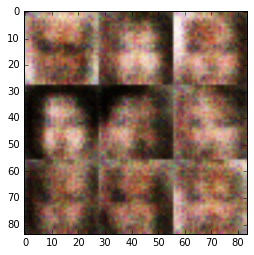

Step: 210: Epoch 1/1... Discriminator Loss: 0.8585... Generator Loss: 1.2443
Step: 220: Epoch 1/1... Discriminator Loss: 0.8246... Generator Loss: 1.4954
Step: 230: Epoch 1/1... Discriminator Loss: 1.0581... Generator Loss: 0.8680
Step: 240: Epoch 1/1... Discriminator Loss: 1.1987... Generator Loss: 2.4666
Step: 250: Epoch 1/1... Discriminator Loss: 1.0335... Generator Loss: 0.9602
Step: 260: Epoch 1/1... Discriminator Loss: 2.2373... Generator Loss: 0.2287
Step: 270: Epoch 1/1... Discriminator Loss: 1.8870... Generator Loss: 0.2877
Step: 280: Epoch 1/1... Discriminator Loss: 1.0158... Generator Loss: 0.9858
Step: 290: Epoch 1/1... Discriminator Loss: 1.7975... Generator Loss: 0.3125
Step: 300: Epoch 1/1... Discriminator Loss: 1.1936... Generator Loss: 2.5193


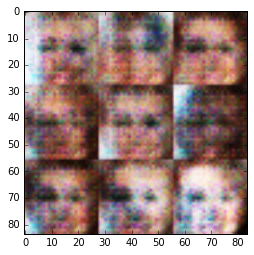

Step: 310: Epoch 1/1... Discriminator Loss: 1.6310... Generator Loss: 0.3807
Step: 320: Epoch 1/1... Discriminator Loss: 0.6861... Generator Loss: 1.6068
Step: 330: Epoch 1/1... Discriminator Loss: 0.7139... Generator Loss: 1.6006
Step: 340: Epoch 1/1... Discriminator Loss: 0.8099... Generator Loss: 2.8098
Step: 350: Epoch 1/1... Discriminator Loss: 0.7021... Generator Loss: 1.4627
Step: 360: Epoch 1/1... Discriminator Loss: 0.9234... Generator Loss: 2.6608
Step: 370: Epoch 1/1... Discriminator Loss: 1.2879... Generator Loss: 2.4642
Step: 380: Epoch 1/1... Discriminator Loss: 0.7180... Generator Loss: 1.4833
Step: 390: Epoch 1/1... Discriminator Loss: 0.9086... Generator Loss: 1.3577
Step: 400: Epoch 1/1... Discriminator Loss: 0.6839... Generator Loss: 1.5581


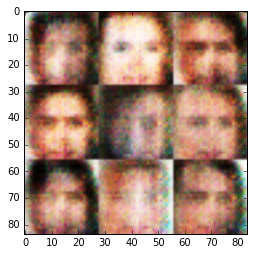

Step: 410: Epoch 1/1... Discriminator Loss: 0.7356... Generator Loss: 1.5359
Step: 420: Epoch 1/1... Discriminator Loss: 0.8746... Generator Loss: 1.2182
Step: 430: Epoch 1/1... Discriminator Loss: 1.6625... Generator Loss: 0.3830
Step: 440: Epoch 1/1... Discriminator Loss: 1.2109... Generator Loss: 0.6760
Step: 450: Epoch 1/1... Discriminator Loss: 0.8153... Generator Loss: 2.9202
Step: 460: Epoch 1/1... Discriminator Loss: 1.6810... Generator Loss: 0.3899
Step: 470: Epoch 1/1... Discriminator Loss: 1.6189... Generator Loss: 0.4051
Step: 480: Epoch 1/1... Discriminator Loss: 1.1443... Generator Loss: 0.6886
Step: 490: Epoch 1/1... Discriminator Loss: 2.0201... Generator Loss: 0.2407
Step: 500: Epoch 1/1... Discriminator Loss: 1.6879... Generator Loss: 0.4109


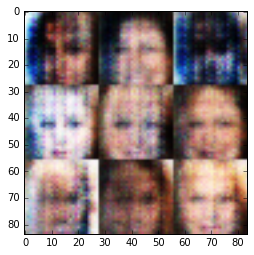

Step: 510: Epoch 1/1... Discriminator Loss: 0.7703... Generator Loss: 1.3790
Step: 520: Epoch 1/1... Discriminator Loss: 0.7680... Generator Loss: 1.2335
Step: 530: Epoch 1/1... Discriminator Loss: 0.6945... Generator Loss: 1.4051
Step: 540: Epoch 1/1... Discriminator Loss: 0.7042... Generator Loss: 1.6133
Step: 550: Epoch 1/1... Discriminator Loss: 2.1745... Generator Loss: 0.2832
Step: 560: Epoch 1/1... Discriminator Loss: 0.9283... Generator Loss: 2.1801
Step: 570: Epoch 1/1... Discriminator Loss: 0.5689... Generator Loss: 1.9254
Step: 580: Epoch 1/1... Discriminator Loss: 0.6742... Generator Loss: 1.8903
Step: 590: Epoch 1/1... Discriminator Loss: 1.5341... Generator Loss: 0.4509
Step: 600: Epoch 1/1... Discriminator Loss: 1.0226... Generator Loss: 0.8056


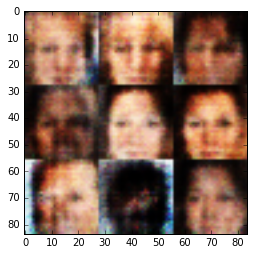

Step: 610: Epoch 1/1... Discriminator Loss: 0.6994... Generator Loss: 1.5909
Step: 620: Epoch 1/1... Discriminator Loss: 0.9363... Generator Loss: 3.2666
Step: 630: Epoch 1/1... Discriminator Loss: 0.6826... Generator Loss: 1.5596
Step: 640: Epoch 1/1... Discriminator Loss: 0.8924... Generator Loss: 2.1213
Step: 650: Epoch 1/1... Discriminator Loss: 0.6335... Generator Loss: 2.2952
Step: 660: Epoch 1/1... Discriminator Loss: 2.0940... Generator Loss: 0.2368
Step: 670: Epoch 1/1... Discriminator Loss: 0.6497... Generator Loss: 1.6026
Step: 680: Epoch 1/1... Discriminator Loss: 0.7764... Generator Loss: 2.6012
Step: 690: Epoch 1/1... Discriminator Loss: 1.0665... Generator Loss: 0.8682
Step: 700: Epoch 1/1... Discriminator Loss: 0.6448... Generator Loss: 1.5637


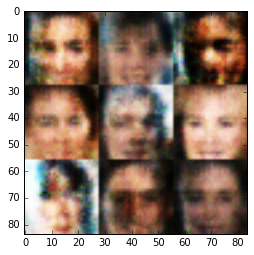

Step: 710: Epoch 1/1... Discriminator Loss: 0.6095... Generator Loss: 1.8367
Step: 720: Epoch 1/1... Discriminator Loss: 0.5599... Generator Loss: 2.6585
Step: 730: Epoch 1/1... Discriminator Loss: 0.6152... Generator Loss: 1.8482
Step: 740: Epoch 1/1... Discriminator Loss: 0.8468... Generator Loss: 2.2160
Step: 750: Epoch 1/1... Discriminator Loss: 0.6499... Generator Loss: 2.0855
Step: 760: Epoch 1/1... Discriminator Loss: 1.3236... Generator Loss: 0.5416
Step: 770: Epoch 1/1... Discriminator Loss: 0.7186... Generator Loss: 1.7092
Step: 780: Epoch 1/1... Discriminator Loss: 0.8866... Generator Loss: 1.0139
Step: 790: Epoch 1/1... Discriminator Loss: 0.8067... Generator Loss: 1.1501
Step: 800: Epoch 1/1... Discriminator Loss: 0.7211... Generator Loss: 1.5852


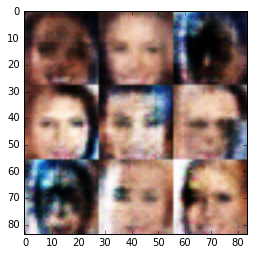

Step: 810: Epoch 1/1... Discriminator Loss: 0.7126... Generator Loss: 1.8278
Step: 820: Epoch 1/1... Discriminator Loss: 0.9684... Generator Loss: 0.8718
Step: 830: Epoch 1/1... Discriminator Loss: 0.7830... Generator Loss: 1.2804
Step: 840: Epoch 1/1... Discriminator Loss: 0.8882... Generator Loss: 1.4786
Step: 850: Epoch 1/1... Discriminator Loss: 0.9242... Generator Loss: 1.9559
Step: 860: Epoch 1/1... Discriminator Loss: 0.8193... Generator Loss: 1.1389
Step: 870: Epoch 1/1... Discriminator Loss: 0.9176... Generator Loss: 2.4030
Step: 880: Epoch 1/1... Discriminator Loss: 0.9217... Generator Loss: 0.9683
Step: 890: Epoch 1/1... Discriminator Loss: 0.8310... Generator Loss: 1.8903
Step: 900: Epoch 1/1... Discriminator Loss: 1.6651... Generator Loss: 0.3927


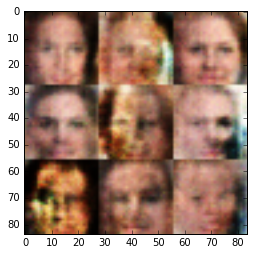

Step: 910: Epoch 1/1... Discriminator Loss: 0.9593... Generator Loss: 0.9512
Step: 920: Epoch 1/1... Discriminator Loss: 0.7860... Generator Loss: 1.2406
Step: 930: Epoch 1/1... Discriminator Loss: 0.7244... Generator Loss: 1.5553
Step: 940: Epoch 1/1... Discriminator Loss: 1.2546... Generator Loss: 1.9408
Step: 950: Epoch 1/1... Discriminator Loss: 0.8786... Generator Loss: 1.1805
Step: 960: Epoch 1/1... Discriminator Loss: 0.7718... Generator Loss: 1.4788
Step: 970: Epoch 1/1... Discriminator Loss: 0.8436... Generator Loss: 1.2346
Step: 980: Epoch 1/1... Discriminator Loss: 0.7406... Generator Loss: 1.5317
Step: 990: Epoch 1/1... Discriminator Loss: 0.9390... Generator Loss: 1.9509
Step: 1000: Epoch 1/1... Discriminator Loss: 1.1321... Generator Loss: 0.7107


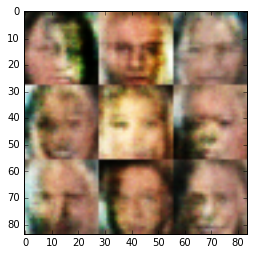

Step: 1010: Epoch 1/1... Discriminator Loss: 0.9737... Generator Loss: 0.9090
Step: 1020: Epoch 1/1... Discriminator Loss: 0.7699... Generator Loss: 1.9954
Step: 1030: Epoch 1/1... Discriminator Loss: 1.4257... Generator Loss: 0.4852
Step: 1040: Epoch 1/1... Discriminator Loss: 1.1566... Generator Loss: 0.7510
Step: 1050: Epoch 1/1... Discriminator Loss: 1.0317... Generator Loss: 0.8792
Step: 1060: Epoch 1/1... Discriminator Loss: 0.6881... Generator Loss: 1.5686
Step: 1070: Epoch 1/1... Discriminator Loss: 0.7855... Generator Loss: 1.5513
Step: 1080: Epoch 1/1... Discriminator Loss: 0.8761... Generator Loss: 2.8790
Step: 1090: Epoch 1/1... Discriminator Loss: 1.7780... Generator Loss: 0.3538
Step: 1100: Epoch 1/1... Discriminator Loss: 0.8950... Generator Loss: 2.0973


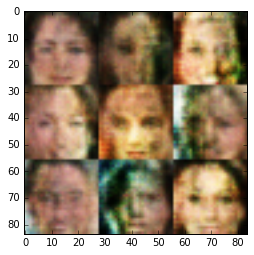

Step: 1110: Epoch 1/1... Discriminator Loss: 0.9568... Generator Loss: 0.8687
Step: 1120: Epoch 1/1... Discriminator Loss: 0.9133... Generator Loss: 1.3410
Step: 1130: Epoch 1/1... Discriminator Loss: 1.6743... Generator Loss: 0.4478
Step: 1140: Epoch 1/1... Discriminator Loss: 1.4149... Generator Loss: 0.4672
Step: 1150: Epoch 1/1... Discriminator Loss: 1.3244... Generator Loss: 0.5697
Step: 1160: Epoch 1/1... Discriminator Loss: 0.8193... Generator Loss: 1.3325
Step: 1170: Epoch 1/1... Discriminator Loss: 0.7748... Generator Loss: 1.7421
Step: 1180: Epoch 1/1... Discriminator Loss: 0.6273... Generator Loss: 1.6655
Step: 1190: Epoch 1/1... Discriminator Loss: 0.6974... Generator Loss: 1.5675
Step: 1200: Epoch 1/1... Discriminator Loss: 0.6901... Generator Loss: 1.5207


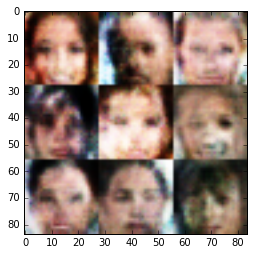

Step: 1210: Epoch 1/1... Discriminator Loss: 0.7679... Generator Loss: 1.3471
Step: 1220: Epoch 1/1... Discriminator Loss: 0.8067... Generator Loss: 2.7848
Step: 1230: Epoch 1/1... Discriminator Loss: 0.6516... Generator Loss: 1.6399
Step: 1240: Epoch 1/1... Discriminator Loss: 0.8730... Generator Loss: 2.6398
Step: 1250: Epoch 1/1... Discriminator Loss: 1.2010... Generator Loss: 0.6243
Step: 1260: Epoch 1/1... Discriminator Loss: 1.6644... Generator Loss: 0.3575
Step: 1270: Epoch 1/1... Discriminator Loss: 0.7193... Generator Loss: 2.0890
Step: 1280: Epoch 1/1... Discriminator Loss: 0.8052... Generator Loss: 1.1535
Step: 1290: Epoch 1/1... Discriminator Loss: 0.7046... Generator Loss: 1.4538
Step: 1300: Epoch 1/1... Discriminator Loss: 0.5848... Generator Loss: 2.0433


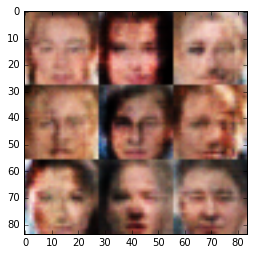

Step: 1310: Epoch 1/1... Discriminator Loss: 0.7554... Generator Loss: 1.2195
Step: 1320: Epoch 1/1... Discriminator Loss: 0.7258... Generator Loss: 1.3417
Step: 1330: Epoch 1/1... Discriminator Loss: 0.3913... Generator Loss: 3.4490
Step: 1340: Epoch 1/1... Discriminator Loss: 2.7150... Generator Loss: 0.1414
Step: 1350: Epoch 1/1... Discriminator Loss: 0.9514... Generator Loss: 0.8819
Step: 1360: Epoch 1/1... Discriminator Loss: 0.5820... Generator Loss: 1.7910
Step: 1370: Epoch 1/1... Discriminator Loss: 1.3453... Generator Loss: 0.5391
Step: 1380: Epoch 1/1... Discriminator Loss: 0.5211... Generator Loss: 2.0282
Step: 1390: Epoch 1/1... Discriminator Loss: 1.1002... Generator Loss: 0.7684
Step: 1400: Epoch 1/1... Discriminator Loss: 0.5144... Generator Loss: 1.9641


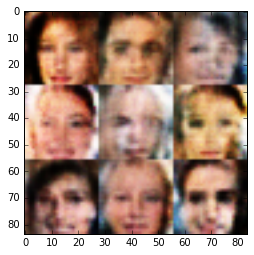

Step: 1410: Epoch 1/1... Discriminator Loss: 0.5108... Generator Loss: 2.1569
Step: 1420: Epoch 1/1... Discriminator Loss: 0.5820... Generator Loss: 1.7116
Step: 1430: Epoch 1/1... Discriminator Loss: 0.5090... Generator Loss: 2.7230
Step: 1440: Epoch 1/1... Discriminator Loss: 0.4066... Generator Loss: 3.5975
Step: 1450: Epoch 1/1... Discriminator Loss: 1.5166... Generator Loss: 2.4542
Step: 1460: Epoch 1/1... Discriminator Loss: 1.2048... Generator Loss: 0.6342
Step: 1470: Epoch 1/1... Discriminator Loss: 0.4229... Generator Loss: 2.8265
Step: 1480: Epoch 1/1... Discriminator Loss: 0.5260... Generator Loss: 2.2577
Step: 1490: Epoch 1/1... Discriminator Loss: 0.4744... Generator Loss: 3.0064
Step: 1500: Epoch 1/1... Discriminator Loss: 0.4297... Generator Loss: 2.8895


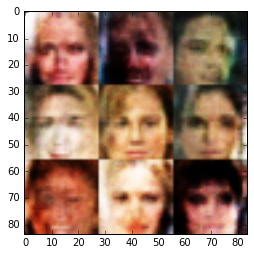

Step: 1510: Epoch 1/1... Discriminator Loss: 0.7703... Generator Loss: 2.4503
Step: 1520: Epoch 1/1... Discriminator Loss: 0.5304... Generator Loss: 2.0296
Step: 1530: Epoch 1/1... Discriminator Loss: 0.4122... Generator Loss: 3.1700
Step: 1540: Epoch 1/1... Discriminator Loss: 0.4578... Generator Loss: 2.6932
Step: 1550: Epoch 1/1... Discriminator Loss: 0.4222... Generator Loss: 3.5838
Step: 1560: Epoch 1/1... Discriminator Loss: 0.4307... Generator Loss: 3.9698
Step: 1570: Epoch 1/1... Discriminator Loss: 0.5203... Generator Loss: 2.0125
Step: 1580: Epoch 1/1... Discriminator Loss: 0.5055... Generator Loss: 2.0603
Step: 1590: Epoch 1/1... Discriminator Loss: 0.7942... Generator Loss: 5.5281
Step: 1600: Epoch 1/1... Discriminator Loss: 1.2845... Generator Loss: 0.6261


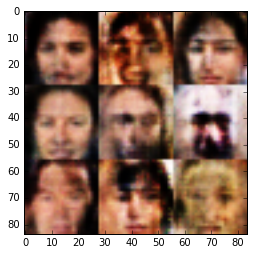

Step: 1610: Epoch 1/1... Discriminator Loss: 0.9384... Generator Loss: 0.9361
Step: 1620: Epoch 1/1... Discriminator Loss: 1.4468... Generator Loss: 0.4619
Step: 1630: Epoch 1/1... Discriminator Loss: 0.5495... Generator Loss: 2.8681
Step: 1640: Epoch 1/1... Discriminator Loss: 0.5947... Generator Loss: 2.9455
Step: 1650: Epoch 1/1... Discriminator Loss: 0.5797... Generator Loss: 3.1505
Step: 1660: Epoch 1/1... Discriminator Loss: 0.4244... Generator Loss: 2.6665
Step: 1670: Epoch 1/1... Discriminator Loss: 0.5876... Generator Loss: 1.6932
Step: 1680: Epoch 1/1... Discriminator Loss: 0.7993... Generator Loss: 1.2586
Step: 1690: Epoch 1/1... Discriminator Loss: 0.7746... Generator Loss: 1.3575
Step: 1700: Epoch 1/1... Discriminator Loss: 0.4366... Generator Loss: 2.7907


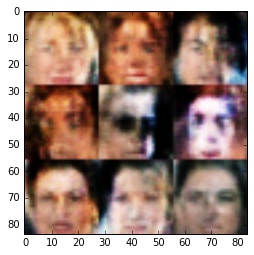

Step: 1710: Epoch 1/1... Discriminator Loss: 0.7911... Generator Loss: 1.1433
Step: 1720: Epoch 1/1... Discriminator Loss: 1.1546... Generator Loss: 0.7165
Step: 1730: Epoch 1/1... Discriminator Loss: 0.5679... Generator Loss: 1.8030
Step: 1740: Epoch 1/1... Discriminator Loss: 0.3775... Generator Loss: 3.8407
Step: 1750: Epoch 1/1... Discriminator Loss: 1.1942... Generator Loss: 5.2588
Step: 1760: Epoch 1/1... Discriminator Loss: 0.7536... Generator Loss: 1.2422
Step: 1770: Epoch 1/1... Discriminator Loss: 0.4290... Generator Loss: 3.1000
Step: 1780: Epoch 1/1... Discriminator Loss: 0.3939... Generator Loss: 4.2675
Step: 1790: Epoch 1/1... Discriminator Loss: 0.4908... Generator Loss: 2.2250
Step: 1800: Epoch 1/1... Discriminator Loss: 0.5382... Generator Loss: 1.8611


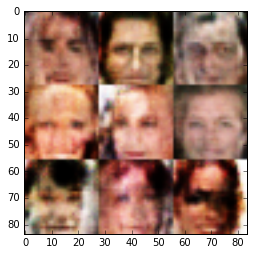

Step: 1810: Epoch 1/1... Discriminator Loss: 0.7449... Generator Loss: 1.1995
Step: 1820: Epoch 1/1... Discriminator Loss: 2.7714... Generator Loss: 0.1608
Step: 1830: Epoch 1/1... Discriminator Loss: 0.4412... Generator Loss: 2.7962
Step: 1840: Epoch 1/1... Discriminator Loss: 1.2385... Generator Loss: 4.4093
Step: 1850: Epoch 1/1... Discriminator Loss: 0.4491... Generator Loss: 4.2811
Step: 1860: Epoch 1/1... Discriminator Loss: 0.7358... Generator Loss: 1.2103
Step: 1870: Epoch 1/1... Discriminator Loss: 0.4401... Generator Loss: 2.6354
Step: 1880: Epoch 1/1... Discriminator Loss: 1.2675... Generator Loss: 4.5336
Step: 1890: Epoch 1/1... Discriminator Loss: 0.4035... Generator Loss: 3.6743
Step: 1900: Epoch 1/1... Discriminator Loss: 0.4084... Generator Loss: 3.4411


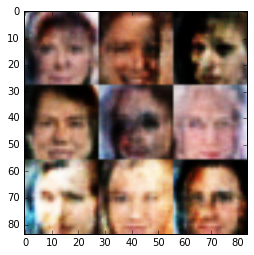

Step: 1910: Epoch 1/1... Discriminator Loss: 0.4569... Generator Loss: 3.5391
Step: 1920: Epoch 1/1... Discriminator Loss: 0.6910... Generator Loss: 1.6664
Step: 1930: Epoch 1/1... Discriminator Loss: 0.7333... Generator Loss: 1.3190
Step: 1940: Epoch 1/1... Discriminator Loss: 1.1076... Generator Loss: 0.6787
Step: 1950: Epoch 1/1... Discriminator Loss: 1.0973... Generator Loss: 0.7587
Step: 1960: Epoch 1/1... Discriminator Loss: 0.6553... Generator Loss: 5.8760
Step: 1970: Epoch 1/1... Discriminator Loss: 0.5658... Generator Loss: 1.8032
Step: 1980: Epoch 1/1... Discriminator Loss: 0.5806... Generator Loss: 1.7415
Step: 1990: Epoch 1/1... Discriminator Loss: 0.4311... Generator Loss: 2.5460
Step: 2000: Epoch 1/1... Discriminator Loss: 0.4066... Generator Loss: 3.4492


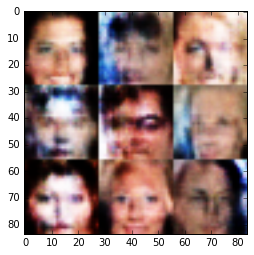

Step: 2010: Epoch 1/1... Discriminator Loss: 0.3849... Generator Loss: 5.0319
Step: 2020: Epoch 1/1... Discriminator Loss: 0.4158... Generator Loss: 2.8970
Step: 2030: Epoch 1/1... Discriminator Loss: 0.5746... Generator Loss: 1.7065
Step: 2040: Epoch 1/1... Discriminator Loss: 0.5129... Generator Loss: 2.0224
Step: 2050: Epoch 1/1... Discriminator Loss: 0.6902... Generator Loss: 5.3685
Step: 2060: Epoch 1/1... Discriminator Loss: 0.4752... Generator Loss: 2.2582
Step: 2070: Epoch 1/1... Discriminator Loss: 0.4942... Generator Loss: 3.6315
Step: 2080: Epoch 1/1... Discriminator Loss: 0.8930... Generator Loss: 5.0376
Step: 2090: Epoch 1/1... Discriminator Loss: 0.4206... Generator Loss: 2.8903
Step: 2100: Epoch 1/1... Discriminator Loss: 1.0620... Generator Loss: 0.7605


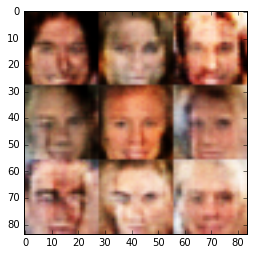

Step: 2110: Epoch 1/1... Discriminator Loss: 0.9614... Generator Loss: 3.7979
Step: 2120: Epoch 1/1... Discriminator Loss: 0.4439... Generator Loss: 2.6507
Step: 2130: Epoch 1/1... Discriminator Loss: 1.4448... Generator Loss: 0.5331
Step: 2140: Epoch 1/1... Discriminator Loss: 1.0502... Generator Loss: 0.7661
Step: 2150: Epoch 1/1... Discriminator Loss: 0.4177... Generator Loss: 3.5226
Step: 2160: Epoch 1/1... Discriminator Loss: 0.5377... Generator Loss: 2.7902
Step: 2170: Epoch 1/1... Discriminator Loss: 0.5016... Generator Loss: 2.1962
Step: 2180: Epoch 1/1... Discriminator Loss: 0.7848... Generator Loss: 1.1606
Step: 2190: Epoch 1/1... Discriminator Loss: 0.5140... Generator Loss: 1.9733
Step: 2200: Epoch 1/1... Discriminator Loss: 0.5032... Generator Loss: 4.0205


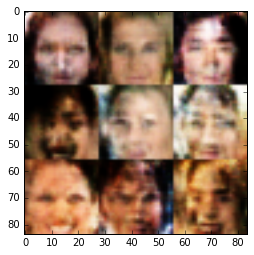

Step: 2210: Epoch 1/1... Discriminator Loss: 0.3678... Generator Loss: 4.3461
Step: 2220: Epoch 1/1... Discriminator Loss: 0.4572... Generator Loss: 2.9824
Step: 2230: Epoch 1/1... Discriminator Loss: 0.4304... Generator Loss: 4.2724
Step: 2240: Epoch 1/1... Discriminator Loss: 1.0389... Generator Loss: 0.7850
Step: 2250: Epoch 1/1... Discriminator Loss: 0.3700... Generator Loss: 3.9476
Step: 2260: Epoch 1/1... Discriminator Loss: 0.5970... Generator Loss: 1.6380
Step: 2270: Epoch 1/1... Discriminator Loss: 0.7319... Generator Loss: 3.1544
Step: 2280: Epoch 1/1... Discriminator Loss: 0.4010... Generator Loss: 3.0604
Step: 2290: Epoch 1/1... Discriminator Loss: 0.4047... Generator Loss: 4.4885
Step: 2300: Epoch 1/1... Discriminator Loss: 0.8728... Generator Loss: 1.0976


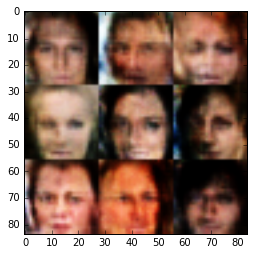

Step: 2310: Epoch 1/1... Discriminator Loss: 0.5220... Generator Loss: 2.1604
Step: 2320: Epoch 1/1... Discriminator Loss: 0.5621... Generator Loss: 5.2970
Step: 2330: Epoch 1/1... Discriminator Loss: 0.3554... Generator Loss: 4.0826
Step: 2340: Epoch 1/1... Discriminator Loss: 0.4012... Generator Loss: 3.2351
Step: 2350: Epoch 1/1... Discriminator Loss: 0.4317... Generator Loss: 2.7379
Step: 2360: Epoch 1/1... Discriminator Loss: 1.5830... Generator Loss: 0.4030
Step: 2370: Epoch 1/1... Discriminator Loss: 1.0871... Generator Loss: 1.0513
Step: 2380: Epoch 1/1... Discriminator Loss: 2.1070... Generator Loss: 0.2628
Step: 2390: Epoch 1/1... Discriminator Loss: 0.6375... Generator Loss: 1.6279
Step: 2400: Epoch 1/1... Discriminator Loss: 0.4775... Generator Loss: 2.3107


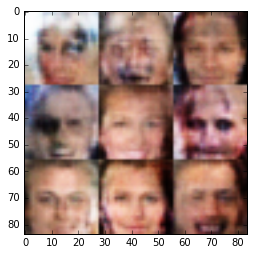

Step: 2410: Epoch 1/1... Discriminator Loss: 1.1621... Generator Loss: 0.6906
Step: 2420: Epoch 1/1... Discriminator Loss: 0.5870... Generator Loss: 1.7207
Step: 2430: Epoch 1/1... Discriminator Loss: 0.4830... Generator Loss: 2.1035
Step: 2440: Epoch 1/1... Discriminator Loss: 0.4998... Generator Loss: 2.2873
Step: 2450: Epoch 1/1... Discriminator Loss: 0.4324... Generator Loss: 4.6340
Step: 2460: Epoch 1/1... Discriminator Loss: 0.5213... Generator Loss: 1.9851
Step: 2470: Epoch 1/1... Discriminator Loss: 0.6553... Generator Loss: 1.5575
Step: 2480: Epoch 1/1... Discriminator Loss: 0.4381... Generator Loss: 2.7403
Step: 2490: Epoch 1/1... Discriminator Loss: 0.5981... Generator Loss: 3.1021
Step: 2500: Epoch 1/1... Discriminator Loss: 0.5772... Generator Loss: 3.2541


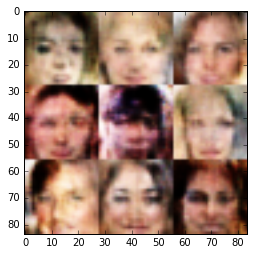

Step: 2510: Epoch 1/1... Discriminator Loss: 0.4016... Generator Loss: 2.9859
Step: 2520: Epoch 1/1... Discriminator Loss: 0.7638... Generator Loss: 1.2701
Step: 2530: Epoch 1/1... Discriminator Loss: 0.3606... Generator Loss: 4.2835
Step: 2540: Epoch 1/1... Discriminator Loss: 0.4703... Generator Loss: 2.2692
Step: 2550: Epoch 1/1... Discriminator Loss: 1.1552... Generator Loss: 0.6815
Step: 2560: Epoch 1/1... Discriminator Loss: 3.0882... Generator Loss: 0.1033
Step: 2570: Epoch 1/1... Discriminator Loss: 0.6419... Generator Loss: 1.5901
Step: 2580: Epoch 1/1... Discriminator Loss: 0.8801... Generator Loss: 0.9863
Step: 2590: Epoch 1/1... Discriminator Loss: 0.5018... Generator Loss: 2.2929
Step: 2600: Epoch 1/1... Discriminator Loss: 0.4627... Generator Loss: 2.3097


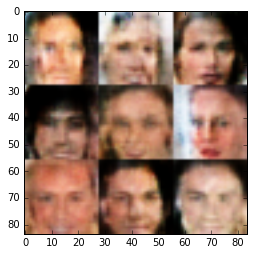

Step: 2610: Epoch 1/1... Discriminator Loss: 0.4193... Generator Loss: 3.8217
Step: 2620: Epoch 1/1... Discriminator Loss: 0.4386... Generator Loss: 2.7369
Step: 2630: Epoch 1/1... Discriminator Loss: 0.5699... Generator Loss: 3.8697
Step: 2640: Epoch 1/1... Discriminator Loss: 0.5129... Generator Loss: 2.2942
Step: 2650: Epoch 1/1... Discriminator Loss: 0.4403... Generator Loss: 3.2241
Step: 2660: Epoch 1/1... Discriminator Loss: 0.4021... Generator Loss: 4.7531
Step: 2670: Epoch 1/1... Discriminator Loss: 0.3996... Generator Loss: 3.5189
Step: 2680: Epoch 1/1... Discriminator Loss: 0.4040... Generator Loss: 3.0221
Step: 2690: Epoch 1/1... Discriminator Loss: 0.4123... Generator Loss: 4.2688
Step: 2700: Epoch 1/1... Discriminator Loss: 0.3937... Generator Loss: 3.9286


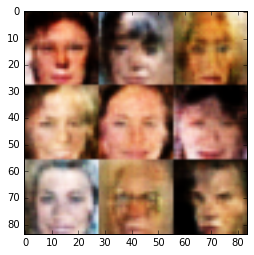

Step: 2710: Epoch 1/1... Discriminator Loss: 0.3476... Generator Loss: 4.4750
Step: 2720: Epoch 1/1... Discriminator Loss: 0.4704... Generator Loss: 4.5432
Step: 2730: Epoch 1/1... Discriminator Loss: 0.7724... Generator Loss: 3.9149
Step: 2740: Epoch 1/1... Discriminator Loss: 0.5921... Generator Loss: 1.7114
Step: 2750: Epoch 1/1... Discriminator Loss: 0.5016... Generator Loss: 2.0545
Step: 2760: Epoch 1/1... Discriminator Loss: 0.4105... Generator Loss: 3.7036
Step: 2770: Epoch 1/1... Discriminator Loss: 0.4218... Generator Loss: 2.9902
Step: 2780: Epoch 1/1... Discriminator Loss: 0.3810... Generator Loss: 3.5144
Step: 2790: Epoch 1/1... Discriminator Loss: 0.4074... Generator Loss: 4.1936
Step: 2800: Epoch 1/1... Discriminator Loss: 0.4167... Generator Loss: 3.0959


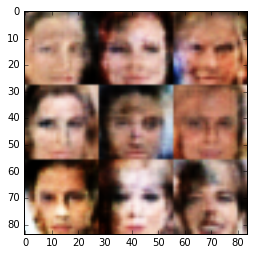

Step: 2810: Epoch 1/1... Discriminator Loss: 0.5640... Generator Loss: 5.6959
Step: 2820: Epoch 1/1... Discriminator Loss: 0.3677... Generator Loss: 3.7283
Step: 2830: Epoch 1/1... Discriminator Loss: 0.4510... Generator Loss: 2.5589
Step: 2840: Epoch 1/1... Discriminator Loss: 0.8588... Generator Loss: 1.0349
Step: 2850: Epoch 1/1... Discriminator Loss: 0.5806... Generator Loss: 1.7610
Step: 2860: Epoch 1/1... Discriminator Loss: 1.4555... Generator Loss: 0.4812
Step: 2870: Epoch 1/1... Discriminator Loss: 0.6710... Generator Loss: 2.8859
Step: 2880: Epoch 1/1... Discriminator Loss: 0.4212... Generator Loss: 3.3959
Step: 2890: Epoch 1/1... Discriminator Loss: 0.7143... Generator Loss: 3.8057
Step: 2900: Epoch 1/1... Discriminator Loss: 0.5048... Generator Loss: 2.1344


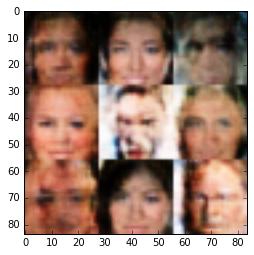

Step: 2910: Epoch 1/1... Discriminator Loss: 0.4669... Generator Loss: 2.9232
Step: 2920: Epoch 1/1... Discriminator Loss: 0.6502... Generator Loss: 1.5261
Step: 2930: Epoch 1/1... Discriminator Loss: 0.4801... Generator Loss: 2.4085
Step: 2940: Epoch 1/1... Discriminator Loss: 0.4368... Generator Loss: 2.6181
Step: 2950: Epoch 1/1... Discriminator Loss: 0.3898... Generator Loss: 3.8317
Step: 2960: Epoch 1/1... Discriminator Loss: 0.4479... Generator Loss: 2.7258
Step: 2970: Epoch 1/1... Discriminator Loss: 0.4687... Generator Loss: 4.7846
Step: 2980: Epoch 1/1... Discriminator Loss: 0.4289... Generator Loss: 2.6883
Step: 2990: Epoch 1/1... Discriminator Loss: 0.4561... Generator Loss: 2.7510
Step: 3000: Epoch 1/1... Discriminator Loss: 1.4268... Generator Loss: 5.7239


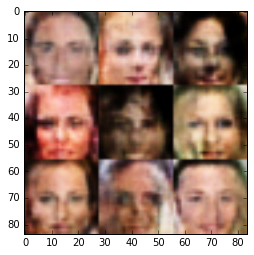

Step: 3010: Epoch 1/1... Discriminator Loss: 0.4192... Generator Loss: 2.7631
Step: 3020: Epoch 1/1... Discriminator Loss: 0.3718... Generator Loss: 3.6650
Step: 3030: Epoch 1/1... Discriminator Loss: 0.4220... Generator Loss: 3.9792
Step: 3040: Epoch 1/1... Discriminator Loss: 0.4204... Generator Loss: 3.0359
Step: 3050: Epoch 1/1... Discriminator Loss: 0.4276... Generator Loss: 3.5440
Step: 3060: Epoch 1/1... Discriminator Loss: 0.4314... Generator Loss: 3.8067
Step: 3070: Epoch 1/1... Discriminator Loss: 0.3989... Generator Loss: 3.0302
Step: 3080: Epoch 1/1... Discriminator Loss: 0.4104... Generator Loss: 3.0172
Step: 3090: Epoch 1/1... Discriminator Loss: 0.6923... Generator Loss: 1.3706
Step: 3100: Epoch 1/1... Discriminator Loss: 0.4650... Generator Loss: 3.2124


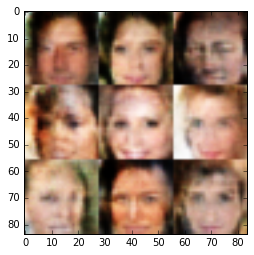

Step: 3110: Epoch 1/1... Discriminator Loss: 0.4361... Generator Loss: 2.4541
Step: 3120: Epoch 1/1... Discriminator Loss: 0.4299... Generator Loss: 5.2931
Step: 3130: Epoch 1/1... Discriminator Loss: 0.5478... Generator Loss: 5.5322
Step: 3140: Epoch 1/1... Discriminator Loss: 0.9852... Generator Loss: 1.4156
Step: 3150: Epoch 1/1... Discriminator Loss: 0.8984... Generator Loss: 1.0462
Step: 3160: Epoch 1/1... Discriminator Loss: 0.7231... Generator Loss: 1.4681
Step: 3170: Epoch 1/1... Discriminator Loss: 0.4604... Generator Loss: 2.5266
Step: 3180: Epoch 1/1... Discriminator Loss: 0.4426... Generator Loss: 3.1277
Step: 3190: Epoch 1/1... Discriminator Loss: 0.4138... Generator Loss: 3.2955
Step: 3200: Epoch 1/1... Discriminator Loss: 0.4312... Generator Loss: 2.8160


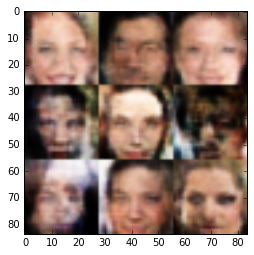

Step: 3210: Epoch 1/1... Discriminator Loss: 0.9449... Generator Loss: 3.9189
Step: 3220: Epoch 1/1... Discriminator Loss: 0.5255... Generator Loss: 2.1044
Step: 3230: Epoch 1/1... Discriminator Loss: 0.5472... Generator Loss: 3.2335
Step: 3240: Epoch 1/1... Discriminator Loss: 0.4844... Generator Loss: 2.9540
Step: 3250: Epoch 1/1... Discriminator Loss: 0.5000... Generator Loss: 2.0972
Step: 3260: Epoch 1/1... Discriminator Loss: 0.4059... Generator Loss: 3.6297
Step: 3270: Epoch 1/1... Discriminator Loss: 0.5672... Generator Loss: 1.7107
Step: 3280: Epoch 1/1... Discriminator Loss: 0.6045... Generator Loss: 1.6566
Step: 3290: Epoch 1/1... Discriminator Loss: 0.4059... Generator Loss: 3.0977
Step: 3300: Epoch 1/1... Discriminator Loss: 0.4471... Generator Loss: 2.5179


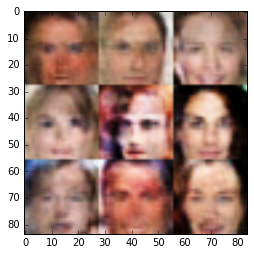

Step: 3310: Epoch 1/1... Discriminator Loss: 0.3431... Generator Loss: 5.4383
Step: 3320: Epoch 1/1... Discriminator Loss: 1.1218... Generator Loss: 0.7987
Step: 3330: Epoch 1/1... Discriminator Loss: 0.8897... Generator Loss: 0.9224
Step: 3340: Epoch 1/1... Discriminator Loss: 0.4856... Generator Loss: 2.8328
Step: 3350: Epoch 1/1... Discriminator Loss: 0.7143... Generator Loss: 1.3232
Step: 3360: Epoch 1/1... Discriminator Loss: 0.5771... Generator Loss: 2.1950
Step: 3370: Epoch 1/1... Discriminator Loss: 0.3744... Generator Loss: 4.4737
Step: 3380: Epoch 1/1... Discriminator Loss: 0.7956... Generator Loss: 2.7358
Step: 3390: Epoch 1/1... Discriminator Loss: 0.6817... Generator Loss: 1.5088
Step: 3400: Epoch 1/1... Discriminator Loss: 0.6939... Generator Loss: 1.6486


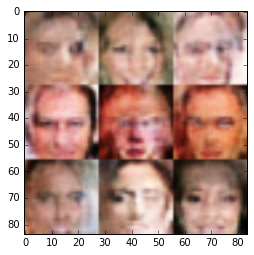

Step: 3410: Epoch 1/1... Discriminator Loss: 0.5234... Generator Loss: 2.0344
Step: 3420: Epoch 1/1... Discriminator Loss: 0.4467... Generator Loss: 2.5639
Step: 3430: Epoch 1/1... Discriminator Loss: 0.6593... Generator Loss: 1.7557
Step: 3440: Epoch 1/1... Discriminator Loss: 0.4474... Generator Loss: 2.4264
Step: 3450: Epoch 1/1... Discriminator Loss: 0.6012... Generator Loss: 1.7536
Step: 3460: Epoch 1/1... Discriminator Loss: 0.9023... Generator Loss: 4.2157
Step: 3470: Epoch 1/1... Discriminator Loss: 0.4773... Generator Loss: 2.4119
Step: 3480: Epoch 1/1... Discriminator Loss: 0.4174... Generator Loss: 3.6063
Step: 3490: Epoch 1/1... Discriminator Loss: 0.4322... Generator Loss: 3.6116
Step: 3500: Epoch 1/1... Discriminator Loss: 0.3643... Generator Loss: 4.2352


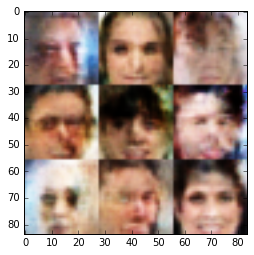

Step: 3510: Epoch 1/1... Discriminator Loss: 0.5263... Generator Loss: 2.0922
Step: 3520: Epoch 1/1... Discriminator Loss: 0.9063... Generator Loss: 3.0106
Step: 3530: Epoch 1/1... Discriminator Loss: 0.4365... Generator Loss: 2.8436
Step: 3540: Epoch 1/1... Discriminator Loss: 0.7024... Generator Loss: 1.4025
Step: 3550: Epoch 1/1... Discriminator Loss: 0.4917... Generator Loss: 2.4682
Step: 3560: Epoch 1/1... Discriminator Loss: 0.4470... Generator Loss: 2.4552
Step: 3570: Epoch 1/1... Discriminator Loss: 0.7359... Generator Loss: 2.2523
Step: 3580: Epoch 1/1... Discriminator Loss: 0.3912... Generator Loss: 3.2631
Step: 3590: Epoch 1/1... Discriminator Loss: 0.7469... Generator Loss: 5.0214
Step: 3600: Epoch 1/1... Discriminator Loss: 0.5367... Generator Loss: 3.5592


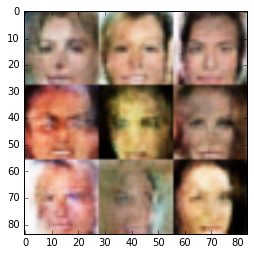

Step: 3610: Epoch 1/1... Discriminator Loss: 0.3543... Generator Loss: 5.3207
Step: 3620: Epoch 1/1... Discriminator Loss: 0.4652... Generator Loss: 2.7733
Step: 3630: Epoch 1/1... Discriminator Loss: 0.3776... Generator Loss: 3.5965
Step: 3640: Epoch 1/1... Discriminator Loss: 0.3866... Generator Loss: 3.3038
Step: 3650: Epoch 1/1... Discriminator Loss: 0.4201... Generator Loss: 3.3202
Step: 3660: Epoch 1/1... Discriminator Loss: 2.0485... Generator Loss: 0.3098
Step: 3670: Epoch 1/1... Discriminator Loss: 1.5238... Generator Loss: 0.5275
Step: 3680: Epoch 1/1... Discriminator Loss: 0.9945... Generator Loss: 1.6916
Step: 3690: Epoch 1/1... Discriminator Loss: 1.4005... Generator Loss: 0.5708
Step: 3700: Epoch 1/1... Discriminator Loss: 0.6943... Generator Loss: 2.0877


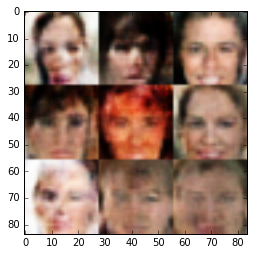

Step: 3710: Epoch 1/1... Discriminator Loss: 0.9926... Generator Loss: 0.8438
Step: 3720: Epoch 1/1... Discriminator Loss: 0.8321... Generator Loss: 1.1196
Step: 3730: Epoch 1/1... Discriminator Loss: 0.5531... Generator Loss: 1.8693
Step: 3740: Epoch 1/1... Discriminator Loss: 0.5456... Generator Loss: 1.9070
Step: 3750: Epoch 1/1... Discriminator Loss: 0.4901... Generator Loss: 2.6411
Step: 3760: Epoch 1/1... Discriminator Loss: 0.3913... Generator Loss: 3.9563
Step: 3770: Epoch 1/1... Discriminator Loss: 0.8541... Generator Loss: 1.0234
Step: 3780: Epoch 1/1... Discriminator Loss: 0.8395... Generator Loss: 3.5588
Step: 3790: Epoch 1/1... Discriminator Loss: 0.4063... Generator Loss: 3.1099
Step: 3800: Epoch 1/1... Discriminator Loss: 0.9852... Generator Loss: 0.8617


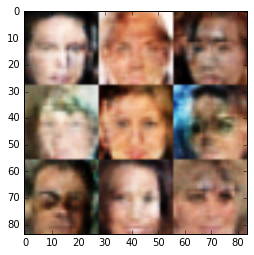

Step: 3810: Epoch 1/1... Discriminator Loss: 0.4171... Generator Loss: 3.1154
Step: 3820: Epoch 1/1... Discriminator Loss: 0.3910... Generator Loss: 3.2067
Step: 3830: Epoch 1/1... Discriminator Loss: 0.4323... Generator Loss: 3.0831
Step: 3840: Epoch 1/1... Discriminator Loss: 0.8289... Generator Loss: 3.8043
Step: 3850: Epoch 1/1... Discriminator Loss: 0.3953... Generator Loss: 3.3324
Step: 3860: Epoch 1/1... Discriminator Loss: 0.4278... Generator Loss: 2.8271
Step: 3870: Epoch 1/1... Discriminator Loss: 0.5138... Generator Loss: 2.2407
Step: 3880: Epoch 1/1... Discriminator Loss: 1.2891... Generator Loss: 0.6142
Step: 3890: Epoch 1/1... Discriminator Loss: 0.6771... Generator Loss: 1.6290
Step: 3900: Epoch 1/1... Discriminator Loss: 0.6236... Generator Loss: 1.6334


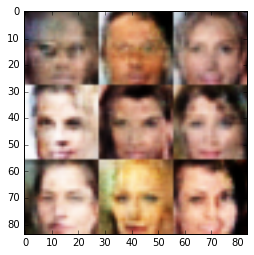

Step: 3910: Epoch 1/1... Discriminator Loss: 0.4515... Generator Loss: 2.9264
Step: 3920: Epoch 1/1... Discriminator Loss: 0.5358... Generator Loss: 1.8981
Step: 3930: Epoch 1/1... Discriminator Loss: 0.4186... Generator Loss: 3.2025
Step: 3940: Epoch 1/1... Discriminator Loss: 0.4177... Generator Loss: 2.9693
Step: 3950: Epoch 1/1... Discriminator Loss: 0.4114... Generator Loss: 2.8364
Step: 3960: Epoch 1/1... Discriminator Loss: 0.3804... Generator Loss: 3.7355
Step: 3970: Epoch 1/1... Discriminator Loss: 0.5382... Generator Loss: 1.9995
Step: 3980: Epoch 1/1... Discriminator Loss: 0.5771... Generator Loss: 1.9396
Step: 3990: Epoch 1/1... Discriminator Loss: 3.3515... Generator Loss: 4.7430
Step: 4000: Epoch 1/1... Discriminator Loss: 1.9514... Generator Loss: 0.3033


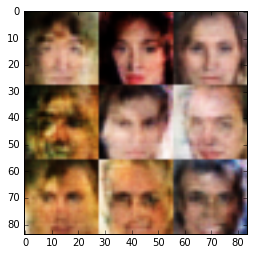

Step: 4010: Epoch 1/1... Discriminator Loss: 0.5113... Generator Loss: 2.6867
Step: 4020: Epoch 1/1... Discriminator Loss: 0.6691... Generator Loss: 1.8913
Step: 4030: Epoch 1/1... Discriminator Loss: 1.2177... Generator Loss: 0.6174
Step: 4040: Epoch 1/1... Discriminator Loss: 0.7585... Generator Loss: 1.1985
Step: 4050: Epoch 1/1... Discriminator Loss: 2.7306... Generator Loss: 4.4586
Step: 4060: Epoch 1/1... Discriminator Loss: 1.2953... Generator Loss: 0.5478
Step: 4070: Epoch 1/1... Discriminator Loss: 0.6527... Generator Loss: 1.6734
Step: 4080: Epoch 1/1... Discriminator Loss: 0.6293... Generator Loss: 1.9247
Step: 4090: Epoch 1/1... Discriminator Loss: 0.5623... Generator Loss: 1.8029
Step: 4100: Epoch 1/1... Discriminator Loss: 1.3063... Generator Loss: 0.5824


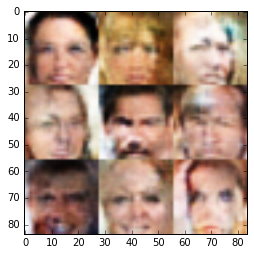

Step: 4110: Epoch 1/1... Discriminator Loss: 0.4256... Generator Loss: 2.8305
Step: 4120: Epoch 1/1... Discriminator Loss: 0.5704... Generator Loss: 1.7358
Step: 4130: Epoch 1/1... Discriminator Loss: 0.5730... Generator Loss: 1.9673
Step: 4140: Epoch 1/1... Discriminator Loss: 0.4788... Generator Loss: 2.1627
Step: 4150: Epoch 1/1... Discriminator Loss: 0.3625... Generator Loss: 5.1574
Step: 4160: Epoch 1/1... Discriminator Loss: 1.7673... Generator Loss: 0.3833
Step: 4170: Epoch 1/1... Discriminator Loss: 0.8198... Generator Loss: 1.1525
Step: 4180: Epoch 1/1... Discriminator Loss: 0.8556... Generator Loss: 3.0934
Step: 4190: Epoch 1/1... Discriminator Loss: 2.4124... Generator Loss: 4.3317
Step: 4200: Epoch 1/1... Discriminator Loss: 1.1506... Generator Loss: 0.7462


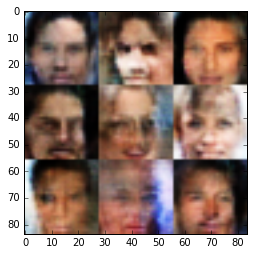

Step: 4210: Epoch 1/1... Discriminator Loss: 0.7242... Generator Loss: 1.3197
Step: 4220: Epoch 1/1... Discriminator Loss: 0.4861... Generator Loss: 2.5104
Step: 4230: Epoch 1/1... Discriminator Loss: 0.5022... Generator Loss: 2.2242
Step: 4240: Epoch 1/1... Discriminator Loss: 0.4276... Generator Loss: 3.1608
Step: 4250: Epoch 1/1... Discriminator Loss: 0.3643... Generator Loss: 4.2202
Step: 4260: Epoch 1/1... Discriminator Loss: 0.4680... Generator Loss: 2.4888
Step: 4270: Epoch 1/1... Discriminator Loss: 0.4084... Generator Loss: 2.9986
Step: 4280: Epoch 1/1... Discriminator Loss: 0.4061... Generator Loss: 3.6075
Step: 4290: Epoch 1/1... Discriminator Loss: 0.4185... Generator Loss: 3.0278
Step: 4300: Epoch 1/1... Discriminator Loss: 0.4497... Generator Loss: 2.6032


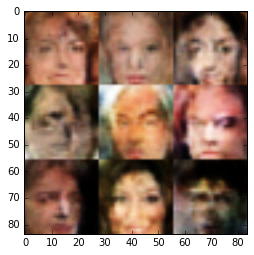

Step: 4310: Epoch 1/1... Discriminator Loss: 0.5187... Generator Loss: 2.1726
Step: 4320: Epoch 1/1... Discriminator Loss: 0.5187... Generator Loss: 2.1301
Step: 4330: Epoch 1/1... Discriminator Loss: 0.4632... Generator Loss: 2.3871
Step: 4340: Epoch 1/1... Discriminator Loss: 0.5484... Generator Loss: 1.8963
Step: 4350: Epoch 1/1... Discriminator Loss: 0.4265... Generator Loss: 2.7471
Step: 4360: Epoch 1/1... Discriminator Loss: 0.5402... Generator Loss: 2.0668
Step: 4370: Epoch 1/1... Discriminator Loss: 0.5063... Generator Loss: 2.1333
Step: 4380: Epoch 1/1... Discriminator Loss: 0.7188... Generator Loss: 1.2362
Step: 4390: Epoch 1/1... Discriminator Loss: 1.9363... Generator Loss: 0.3220
Step: 4400: Epoch 1/1... Discriminator Loss: 1.7697... Generator Loss: 0.4819


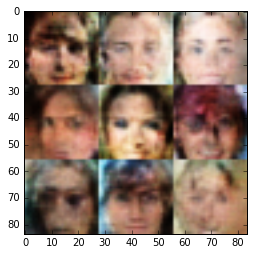

Step: 4410: Epoch 1/1... Discriminator Loss: 2.7372... Generator Loss: 5.0454
Step: 4420: Epoch 1/1... Discriminator Loss: 0.7601... Generator Loss: 1.8673
Step: 4430: Epoch 1/1... Discriminator Loss: 0.4782... Generator Loss: 2.5015
Step: 4440: Epoch 1/1... Discriminator Loss: 0.8500... Generator Loss: 1.1158
Step: 4450: Epoch 1/1... Discriminator Loss: 0.6028... Generator Loss: 1.9904
Step: 4460: Epoch 1/1... Discriminator Loss: 0.5066... Generator Loss: 2.4833
Step: 4470: Epoch 1/1... Discriminator Loss: 0.3522... Generator Loss: 4.2906
Step: 4480: Epoch 1/1... Discriminator Loss: 0.8935... Generator Loss: 0.9528
Step: 4490: Epoch 1/1... Discriminator Loss: 0.6502... Generator Loss: 1.6278
Step: 4500: Epoch 1/1... Discriminator Loss: 0.4092... Generator Loss: 3.1417


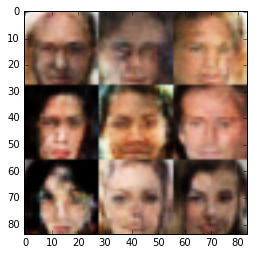

Step: 4510: Epoch 1/1... Discriminator Loss: 0.4587... Generator Loss: 2.4910
Step: 4520: Epoch 1/1... Discriminator Loss: 0.5600... Generator Loss: 2.0052
Step: 4530: Epoch 1/1... Discriminator Loss: 0.4041... Generator Loss: 3.0025
Step: 4540: Epoch 1/1... Discriminator Loss: 0.7158... Generator Loss: 3.1341
Step: 4550: Epoch 1/1... Discriminator Loss: 0.7922... Generator Loss: 3.4807
Step: 4560: Epoch 1/1... Discriminator Loss: 0.6648... Generator Loss: 1.4931
Step: 4570: Epoch 1/1... Discriminator Loss: 0.5162... Generator Loss: 2.2024
Step: 4580: Epoch 1/1... Discriminator Loss: 0.4155... Generator Loss: 3.6745
Step: 4590: Epoch 1/1... Discriminator Loss: 0.4086... Generator Loss: 3.3540
Step: 4600: Epoch 1/1... Discriminator Loss: 0.4129... Generator Loss: 3.4209


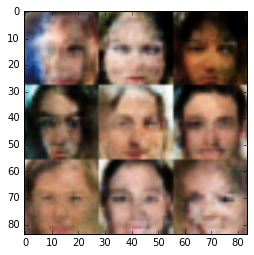

Step: 4610: Epoch 1/1... Discriminator Loss: 0.9475... Generator Loss: 4.2545
Step: 4620: Epoch 1/1... Discriminator Loss: 0.5533... Generator Loss: 2.6365
Step: 4630: Epoch 1/1... Discriminator Loss: 0.4169... Generator Loss: 2.7913
Step: 4640: Epoch 1/1... Discriminator Loss: 0.4866... Generator Loss: 2.5438
Step: 4650: Epoch 1/1... Discriminator Loss: 0.4243... Generator Loss: 2.9533
Step: 4660: Epoch 1/1... Discriminator Loss: 0.4665... Generator Loss: 2.3197
Step: 4670: Epoch 1/1... Discriminator Loss: 0.4643... Generator Loss: 2.3582
Step: 4680: Epoch 1/1... Discriminator Loss: 0.4907... Generator Loss: 2.2256
Step: 4690: Epoch 1/1... Discriminator Loss: 0.7450... Generator Loss: 1.3344
Step: 4700: Epoch 1/1... Discriminator Loss: 0.8666... Generator Loss: 2.5755


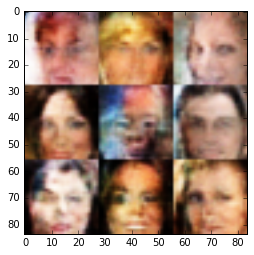

Step: 4710: Epoch 1/1... Discriminator Loss: 0.5492... Generator Loss: 2.4628
Step: 4720: Epoch 1/1... Discriminator Loss: 0.4814... Generator Loss: 2.2455
Step: 4730: Epoch 1/1... Discriminator Loss: 0.7831... Generator Loss: 1.2391
Step: 4740: Epoch 1/1... Discriminator Loss: 0.4373... Generator Loss: 2.6188
Step: 4750: Epoch 1/1... Discriminator Loss: 0.5486... Generator Loss: 1.8497
Step: 4760: Epoch 1/1... Discriminator Loss: 0.4323... Generator Loss: 2.6391
Step: 4770: Epoch 1/1... Discriminator Loss: 0.6309... Generator Loss: 1.4970
Step: 4780: Epoch 1/1... Discriminator Loss: 0.4218... Generator Loss: 3.0369
Step: 4790: Epoch 1/1... Discriminator Loss: 0.4180... Generator Loss: 3.8519
Step: 4800: Epoch 1/1... Discriminator Loss: 0.7133... Generator Loss: 1.4965


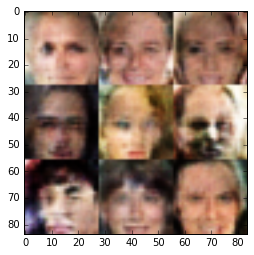

Step: 4810: Epoch 1/1... Discriminator Loss: 0.4617... Generator Loss: 2.7605
Step: 4820: Epoch 1/1... Discriminator Loss: 0.4778... Generator Loss: 2.3098
Step: 4830: Epoch 1/1... Discriminator Loss: 0.5358... Generator Loss: 2.3550
Step: 4840: Epoch 1/1... Discriminator Loss: 0.4965... Generator Loss: 2.4862
Step: 4850: Epoch 1/1... Discriminator Loss: 0.5074... Generator Loss: 1.9636
Step: 4860: Epoch 1/1... Discriminator Loss: 0.6933... Generator Loss: 1.4822
Step: 4870: Epoch 1/1... Discriminator Loss: 0.9215... Generator Loss: 1.0113
Step: 4880: Epoch 1/1... Discriminator Loss: 0.3991... Generator Loss: 4.3324
Step: 4890: Epoch 1/1... Discriminator Loss: 0.6771... Generator Loss: 1.3909
Step: 4900: Epoch 1/1... Discriminator Loss: 1.1286... Generator Loss: 2.2756


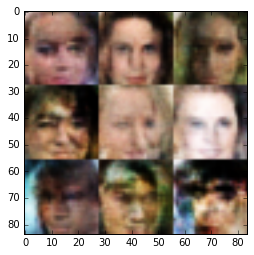

Step: 4910: Epoch 1/1... Discriminator Loss: 2.9898... Generator Loss: 5.1727
Step: 4920: Epoch 1/1... Discriminator Loss: 1.1156... Generator Loss: 0.7741
Step: 4930: Epoch 1/1... Discriminator Loss: 0.3954... Generator Loss: 3.5659
Step: 4940: Epoch 1/1... Discriminator Loss: 0.5942... Generator Loss: 2.7112
Step: 4950: Epoch 1/1... Discriminator Loss: 0.4466... Generator Loss: 3.0726
Step: 4960: Epoch 1/1... Discriminator Loss: 1.0208... Generator Loss: 0.8145
Step: 4970: Epoch 1/1... Discriminator Loss: 0.3970... Generator Loss: 3.2461
Step: 4980: Epoch 1/1... Discriminator Loss: 0.5863... Generator Loss: 1.6773
Step: 4990: Epoch 1/1... Discriminator Loss: 0.5070... Generator Loss: 2.6331
Step: 5000: Epoch 1/1... Discriminator Loss: 0.4086... Generator Loss: 3.1094


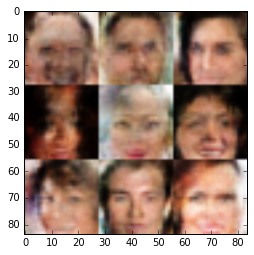

Step: 5010: Epoch 1/1... Discriminator Loss: 0.4123... Generator Loss: 3.0912
Step: 5020: Epoch 1/1... Discriminator Loss: 0.5063... Generator Loss: 2.2436
Step: 5030: Epoch 1/1... Discriminator Loss: 0.5132... Generator Loss: 1.9223
Step: 5040: Epoch 1/1... Discriminator Loss: 0.5058... Generator Loss: 2.0428
Step: 5050: Epoch 1/1... Discriminator Loss: 0.6182... Generator Loss: 1.6787
Step: 5060: Epoch 1/1... Discriminator Loss: 0.4176... Generator Loss: 2.6805
Step: 5070: Epoch 1/1... Discriminator Loss: 0.5969... Generator Loss: 1.6829
Step: 5080: Epoch 1/1... Discriminator Loss: 0.4726... Generator Loss: 2.8313
Step: 5090: Epoch 1/1... Discriminator Loss: 0.4857... Generator Loss: 2.7449
Step: 5100: Epoch 1/1... Discriminator Loss: 0.5371... Generator Loss: 3.2672


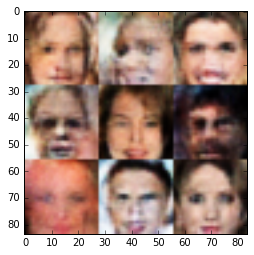

Step: 5110: Epoch 1/1... Discriminator Loss: 0.6679... Generator Loss: 1.5940
Step: 5120: Epoch 1/1... Discriminator Loss: 0.5002... Generator Loss: 2.5516
Step: 5130: Epoch 1/1... Discriminator Loss: 1.7652... Generator Loss: 3.7038
Step: 5140: Epoch 1/1... Discriminator Loss: 0.5306... Generator Loss: 1.9994
Step: 5150: Epoch 1/1... Discriminator Loss: 0.5243... Generator Loss: 2.1027
Step: 5160: Epoch 1/1... Discriminator Loss: 0.4736... Generator Loss: 2.7248
Step: 5170: Epoch 1/1... Discriminator Loss: 0.4261... Generator Loss: 2.8340
Step: 5180: Epoch 1/1... Discriminator Loss: 0.4833... Generator Loss: 2.2579
Step: 5190: Epoch 1/1... Discriminator Loss: 0.5900... Generator Loss: 1.6890
Step: 5200: Epoch 1/1... Discriminator Loss: 0.7052... Generator Loss: 1.2495


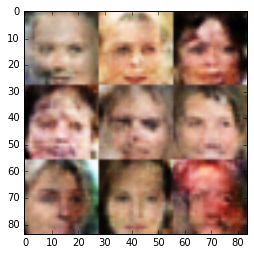

Step: 5210: Epoch 1/1... Discriminator Loss: 0.4070... Generator Loss: 3.4024
Step: 5220: Epoch 1/1... Discriminator Loss: 0.6116... Generator Loss: 1.6292
Step: 5230: Epoch 1/1... Discriminator Loss: 0.4297... Generator Loss: 5.1783
Step: 5240: Epoch 1/1... Discriminator Loss: 0.6020... Generator Loss: 2.9761
Step: 5250: Epoch 1/1... Discriminator Loss: 0.4103... Generator Loss: 3.1533
Step: 5260: Epoch 1/1... Discriminator Loss: 0.3686... Generator Loss: 6.3811
Step: 5270: Epoch 1/1... Discriminator Loss: 0.4534... Generator Loss: 2.6541
Step: 5280: Epoch 1/1... Discriminator Loss: 0.3783... Generator Loss: 3.5897
Step: 5290: Epoch 1/1... Discriminator Loss: 1.1128... Generator Loss: 0.8431
Step: 5300: Epoch 1/1... Discriminator Loss: 0.6194... Generator Loss: 1.6477


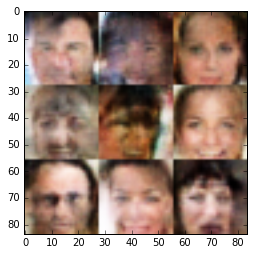

Step: 5310: Epoch 1/1... Discriminator Loss: 0.7422... Generator Loss: 1.4903
Step: 5320: Epoch 1/1... Discriminator Loss: 0.5526... Generator Loss: 2.6766
Step: 5330: Epoch 1/1... Discriminator Loss: 0.5014... Generator Loss: 2.1453
Step: 5340: Epoch 1/1... Discriminator Loss: 0.7107... Generator Loss: 1.4508
Step: 5350: Epoch 1/1... Discriminator Loss: 0.3916... Generator Loss: 3.9624
Step: 5360: Epoch 1/1... Discriminator Loss: 0.4257... Generator Loss: 3.2879
Step: 5370: Epoch 1/1... Discriminator Loss: 0.4763... Generator Loss: 2.4653
Step: 5380: Epoch 1/1... Discriminator Loss: 0.7906... Generator Loss: 2.9862
Step: 5390: Epoch 1/1... Discriminator Loss: 0.5257... Generator Loss: 1.9649
Step: 5400: Epoch 1/1... Discriminator Loss: 0.4338... Generator Loss: 3.5172


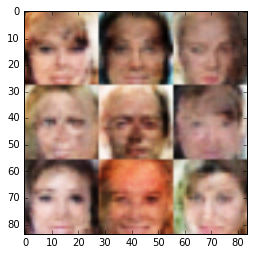

Step: 5410: Epoch 1/1... Discriminator Loss: 0.3545... Generator Loss: 5.1532
Step: 5420: Epoch 1/1... Discriminator Loss: 0.4067... Generator Loss: 3.2319
Step: 5430: Epoch 1/1... Discriminator Loss: 0.8184... Generator Loss: 1.0649
Step: 5440: Epoch 1/1... Discriminator Loss: 0.4141... Generator Loss: 2.9586
Step: 5450: Epoch 1/1... Discriminator Loss: 0.3992... Generator Loss: 3.2659
Step: 5460: Epoch 1/1... Discriminator Loss: 1.8922... Generator Loss: 0.3565
Step: 5470: Epoch 1/1... Discriminator Loss: 0.5582... Generator Loss: 2.1688
Step: 5480: Epoch 1/1... Discriminator Loss: 0.8921... Generator Loss: 1.0778
Step: 5490: Epoch 1/1... Discriminator Loss: 0.7510... Generator Loss: 2.6352
Step: 5500: Epoch 1/1... Discriminator Loss: 1.0792... Generator Loss: 2.3783


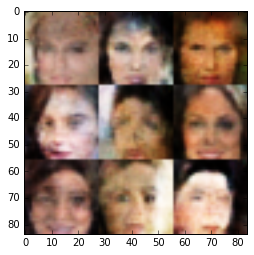

Step: 5510: Epoch 1/1... Discriminator Loss: 0.9341... Generator Loss: 0.9213
Step: 5520: Epoch 1/1... Discriminator Loss: 0.4927... Generator Loss: 2.5072
Step: 5530: Epoch 1/1... Discriminator Loss: 0.3538... Generator Loss: 5.3068
Step: 5540: Epoch 1/1... Discriminator Loss: 0.3833... Generator Loss: 4.1585
Step: 5550: Epoch 1/1... Discriminator Loss: 0.3622... Generator Loss: 4.5253
Step: 5560: Epoch 1/1... Discriminator Loss: 0.3685... Generator Loss: 4.5492
Step: 5570: Epoch 1/1... Discriminator Loss: 0.3760... Generator Loss: 4.0954
Step: 5580: Epoch 1/1... Discriminator Loss: 0.5044... Generator Loss: 4.0678
Step: 5590: Epoch 1/1... Discriminator Loss: 0.4924... Generator Loss: 2.1530
Step: 5600: Epoch 1/1... Discriminator Loss: 0.3558... Generator Loss: 4.9970


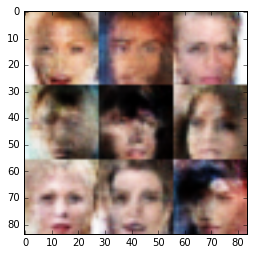

Step: 5610: Epoch 1/1... Discriminator Loss: 0.5242... Generator Loss: 1.9826
Step: 5620: Epoch 1/1... Discriminator Loss: 1.6156... Generator Loss: 0.4458
Step: 5630: Epoch 1/1... Discriminator Loss: 0.9069... Generator Loss: 2.4485
Step: 5640: Epoch 1/1... Discriminator Loss: 0.5499... Generator Loss: 2.2038
Step: 5650: Epoch 1/1... Discriminator Loss: 0.5466... Generator Loss: 1.8794
Step: 5660: Epoch 1/1... Discriminator Loss: 0.5091... Generator Loss: 3.7028
Step: 5670: Epoch 1/1... Discriminator Loss: 0.4113... Generator Loss: 2.9091
Step: 5680: Epoch 1/1... Discriminator Loss: 0.5114... Generator Loss: 4.3119
Step: 5690: Epoch 1/1... Discriminator Loss: 0.4291... Generator Loss: 2.8304
Step: 5700: Epoch 1/1... Discriminator Loss: 0.3937... Generator Loss: 5.1839


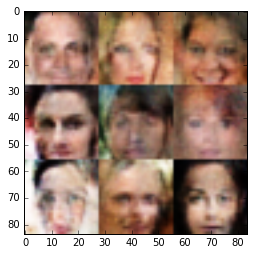

Step: 5710: Epoch 1/1... Discriminator Loss: 0.6088... Generator Loss: 1.7573
Step: 5720: Epoch 1/1... Discriminator Loss: 0.4063... Generator Loss: 3.1384
Step: 5730: Epoch 1/1... Discriminator Loss: 0.4297... Generator Loss: 3.0511
Step: 5740: Epoch 1/1... Discriminator Loss: 0.6360... Generator Loss: 1.6792
Step: 5750: Epoch 1/1... Discriminator Loss: 0.8156... Generator Loss: 1.2848
Step: 5760: Epoch 1/1... Discriminator Loss: 0.5028... Generator Loss: 2.1237
Step: 5770: Epoch 1/1... Discriminator Loss: 0.4776... Generator Loss: 2.3018
Step: 5780: Epoch 1/1... Discriminator Loss: 0.4203... Generator Loss: 3.6313
Step: 5790: Epoch 1/1... Discriminator Loss: 0.4515... Generator Loss: 2.8531
Step: 5800: Epoch 1/1... Discriminator Loss: 0.4183... Generator Loss: 2.9982


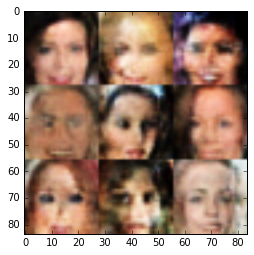

Step: 5810: Epoch 1/1... Discriminator Loss: 0.4351... Generator Loss: 3.2867
Step: 5820: Epoch 1/1... Discriminator Loss: 0.7687... Generator Loss: 1.3446
Step: 5830: Epoch 1/1... Discriminator Loss: 0.4837... Generator Loss: 2.2589
Step: 5840: Epoch 1/1... Discriminator Loss: 0.3891... Generator Loss: 4.9048
Step: 5850: Epoch 1/1... Discriminator Loss: 0.4784... Generator Loss: 2.2895
Step: 5860: Epoch 1/1... Discriminator Loss: 0.4300... Generator Loss: 2.6978
Step: 5870: Epoch 1/1... Discriminator Loss: 0.4306... Generator Loss: 2.9945
Step: 5880: Epoch 1/1... Discriminator Loss: 0.5741... Generator Loss: 1.8547
Step: 5890: Epoch 1/1... Discriminator Loss: 0.5154... Generator Loss: 2.2084
Step: 5900: Epoch 1/1... Discriminator Loss: 0.5953... Generator Loss: 2.5127


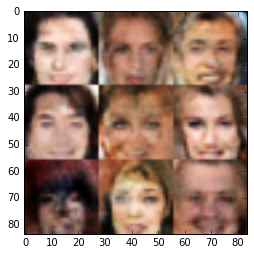

Step: 5910: Epoch 1/1... Discriminator Loss: 0.3885... Generator Loss: 3.3311
Step: 5920: Epoch 1/1... Discriminator Loss: 1.2070... Generator Loss: 4.9897
Step: 5930: Epoch 1/1... Discriminator Loss: 0.6409... Generator Loss: 1.6401
Step: 5940: Epoch 1/1... Discriminator Loss: 1.5063... Generator Loss: 0.5370
Step: 5950: Epoch 1/1... Discriminator Loss: 0.6784... Generator Loss: 2.6340
Step: 5960: Epoch 1/1... Discriminator Loss: 0.7475... Generator Loss: 3.2924
Step: 5970: Epoch 1/1... Discriminator Loss: 0.4545... Generator Loss: 2.5544
Step: 5980: Epoch 1/1... Discriminator Loss: 0.6241... Generator Loss: 1.6111
Step: 5990: Epoch 1/1... Discriminator Loss: 0.6055... Generator Loss: 1.6698
Step: 6000: Epoch 1/1... Discriminator Loss: 0.4221... Generator Loss: 2.8280


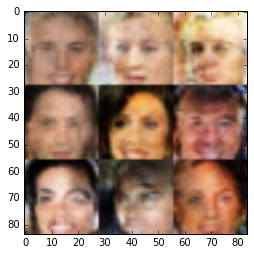

Step: 6010: Epoch 1/1... Discriminator Loss: 0.6896... Generator Loss: 1.3462
Step: 6020: Epoch 1/1... Discriminator Loss: 0.3988... Generator Loss: 3.1845
Step: 6030: Epoch 1/1... Discriminator Loss: 2.7117... Generator Loss: 5.9170
Step: 6040: Epoch 1/1... Discriminator Loss: 2.3060... Generator Loss: 0.2871
Step: 6050: Epoch 1/1... Discriminator Loss: 1.2252... Generator Loss: 0.6653
Step: 6060: Epoch 1/1... Discriminator Loss: 1.0744... Generator Loss: 0.9347
Step: 6070: Epoch 1/1... Discriminator Loss: 0.4390... Generator Loss: 2.8853
Step: 6080: Epoch 1/1... Discriminator Loss: 0.9164... Generator Loss: 4.1811
Step: 6090: Epoch 1/1... Discriminator Loss: 0.9147... Generator Loss: 1.0346
Step: 6100: Epoch 1/1... Discriminator Loss: 0.8337... Generator Loss: 1.2346


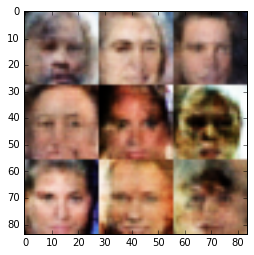

Step: 6110: Epoch 1/1... Discriminator Loss: 0.5977... Generator Loss: 1.6490
Step: 6120: Epoch 1/1... Discriminator Loss: 0.5157... Generator Loss: 2.0896
Step: 6130: Epoch 1/1... Discriminator Loss: 0.5185... Generator Loss: 2.1131
Step: 6140: Epoch 1/1... Discriminator Loss: 0.4335... Generator Loss: 3.4361
Step: 6150: Epoch 1/1... Discriminator Loss: 0.4234... Generator Loss: 2.7944
Step: 6160: Epoch 1/1... Discriminator Loss: 0.4323... Generator Loss: 3.0244
Step: 6170: Epoch 1/1... Discriminator Loss: 0.4207... Generator Loss: 3.3288
Step: 6180: Epoch 1/1... Discriminator Loss: 0.4650... Generator Loss: 2.4757
Step: 6190: Epoch 1/1... Discriminator Loss: 0.4750... Generator Loss: 2.2488
Step: 6200: Epoch 1/1... Discriminator Loss: 0.3812... Generator Loss: 3.5968


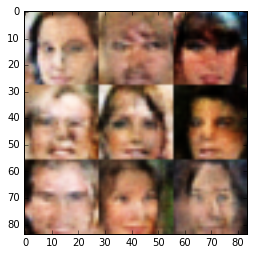

Step: 6210: Epoch 1/1... Discriminator Loss: 1.7487... Generator Loss: 0.4022
Step: 6220: Epoch 1/1... Discriminator Loss: 0.3827... Generator Loss: 3.7595
Step: 6230: Epoch 1/1... Discriminator Loss: 0.4132... Generator Loss: 3.1883
Step: 6240: Epoch 1/1... Discriminator Loss: 0.6401... Generator Loss: 4.0235
Step: 6250: Epoch 1/1... Discriminator Loss: 0.4704... Generator Loss: 2.4509
Step: 6260: Epoch 1/1... Discriminator Loss: 0.4885... Generator Loss: 2.2954
Step: 6270: Epoch 1/1... Discriminator Loss: 0.4123... Generator Loss: 2.9447
Step: 6280: Epoch 1/1... Discriminator Loss: 0.5214... Generator Loss: 2.0898
Step: 6290: Epoch 1/1... Discriminator Loss: 1.0018... Generator Loss: 0.9963
Step: 6300: Epoch 1/1... Discriminator Loss: 0.4642... Generator Loss: 2.5097


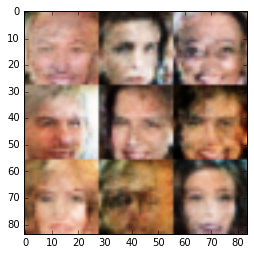

Step: 6310: Epoch 1/1... Discriminator Loss: 0.3666... Generator Loss: 4.8471
Step: 6320: Epoch 1/1... Discriminator Loss: 0.4552... Generator Loss: 2.5142
Step: 6330: Epoch 1/1... Discriminator Loss: 0.3819... Generator Loss: 3.7548
Finished with trainning


In [39]:
batch_size = 32
z_dim = 200
learning_rate = 0.0002
beta1 = 0.3

epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Enviando este projeto
Ao enviar este projeto, certifique-se de executar todas as células antes de salvar o bloco de anotações. Salve o arquivo do notebook como "dlnd_face_generation.ipynb" e salve-o como um arquivo HTML em "File" -> "Download as". Inclua os arquivos "helper.py" e "problem_unittests.py" no seu envio.